# PROYECTO TriDxPulse



*   **Integrantes:** Patricio Abarca, Leonardo Solis, Rodrigo Tapia



## 0: Configuración

En esta sección, se importan todas las bibliotecas necesarias (TensorFlow, Keras, PyTorch, Hugging Face, Scikit-learn, Librosa, etc.) y se configuran las semillas aleatorias (random seed) para garantizar la reproducibilidad de los experimentos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importaciones de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
import os
import glob # Para buscar archivos

# (Si se usa Hugging Face)
# from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# (Para Interpretabilidad)
# import shap
# import lime
# (Para Grad-CAM)
# ...

# Configuración de Semillas para Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Definición de rutas (Paths)
IMAGE_DATA_PATH = "/content/drive/MyDrive/dataset_final_lab_03/photos"
AUDIO_DATA_PATH = "/content/drive/MyDrive/dataset_final_lab_03/coughvid_balanced"
TEXT_DATA_PATH = "/content/drive/MyDrive/dataset_final_lab_03/text_dataset.csv"
MASTER_DATASET_PATH ="/content/drive/MyDrive/dataset_final_lab_03"

## 1. Definición del Proyecto (Objetivos, Hipótesis e Interrogantes)

Esta sección replica los fundamentos del proyecto definidos en el documento de la tarea, sirviendo como guía y recordatorio de los objetivos a cumplir.

### 1.1. Objetivo General

Desarrollar un prototipo funcional basado en tecnologías de IA para la detección temprana de enfermedades respiratorias mediante el análisis multimodal de imágenes de rayos X, audio de tos y descripciones textuales de síntomas, utilizando redes convolucionales, recurrentes o transformer de tipo propio o preentrenado en Python y Google Colab.

### 1.2. Objetivos Específicos

* Identificar y adquirir datasets públicos relevantes para imágenes, audio y texto relacionados con enfermedades respiratorias, complementados con datos etiquetados manualmente por el grupo.
* Realizar un análisis exploratorio de datos (EDA) para entender la distribución y calidad de los datasets multimodales.
* Diseñar y entrenar modelos específicos: CNN con transfer learning para procesamiento de imágenes, Transformers para NLP en descripciones de síntomas, y redes neuronales (incluyendo recurrentes) para análisis de audio de tos.
* Integrar los modelos multimodales en un pipeline unificado para predicciones combinadas.
* Evaluar el rendimiento del prototipo mediante métricas como precisión, recall y F1-score, y analizar su interpretabilidad.
* Documentar el proceso y resultados para demostrar el aprendizaje en redes recurrentes y convolucionales.

### 1.3. Hipótesis

* Hp1 (Principal): La integración multimodal [...] permitirá detectar enfermedades respiratorias [...] con una precisión global superior al 85% y un recall superior al 80%.
* Hp2 (Imágenes): El uso de transfer learning con una CNN preentrenada [...] para el análisis de imágenes de rayos X logrará una precisión superior al 85%.
* Hs3 (Audio): El análisis de audio de tos mediante redes recurrentes (LSTM o GRU) [...] permitirá clasificar patrones de tos [...] con una precisión superior al 75%, mejorando hasta un 80% al incorporar datos etiquetados manualmente.
* Hs4 (Texto): El procesamiento de descripciones textuales de síntomas con un modelo Transformer [...] identificará patrones semánticos relevantes con una precisión superior al 80%.
* Hs5 (Fusión): La fusión multimodal [...] mejorará la precisión global del prototipo en al menos un 5% respecto a los modelos unimodales.
* Hs6 (Datos Manuales): La incorporación de datos etiquetados manually [...] mejorará el rendimiento de los modelos en al menos un 3%.
* Hipótesis de Interpretabilidad (Hip): La aplicación de técnicas de interpretabilidad como SHAP y LIME [...] permitirá explicar al menos el 70% de las predicciones del sistema.
* Hi1 (Imágenes): El uso de SHAP en las CNN [...] explicará al menos el 80% de las predicciones individuales.
* Hi2 (Audio): La aplicación de LIME a las redes recurrentes [...] permitirá interpretar al menos el 75% de las clasificaciones.
* Hi3 (Texto): SHAP o LIME en los modelos Transformer [...] explicará al menos el 85% de las contribuciones semánticas.
* Hi4 (Fusión): La integración de técnicas de interpretabilidad en la fusión multimodal [...] logrará una explicación global superior al 70%.

### 1.4. Interrogantes a Resolver

1. ¿Cuáles son los datasets públicos más adecuados para cada modalidad (imágenes,
audio, texto) y cómo integrarlos con datos manuales para evitar sesgos?
2. ¿Qué arquitecturas de modelos (e.g., ResNet para CNN, BERT para NLP, ¿LSTM para audio) ofrecen el mejor equilibrio entre precisión y eficiencia computacional en Google Colab?
3. ¿Cómo fusionar las predicciones multimodales para maximizar la precisión global del prototipo?
4. ¿Qué métricas de evaluación son más relevantes para un sistema de detección temprana, considerando el impacto en falsos positivos/negativos?
5. ¿Cómo garantizar la interpretabilidad de los modelos para que los resultados sean explicables en un contexto médico?
6. ¿Cuál es el impacto de los datos etiquetados manualmente en la mejora del rendimiento del modelo?

## 2. Adquisición y Preprocesamiento de Datos

La adquisición y preparación de los datasets unimodales es la etapa más crítica del proyecto, ya que la calidad de estos impactará directamente en el rendimiento de los "modelos expertos" individuales y, por ende, en el sistema de fusión final.

En esta etapa, nos enfocaremos en preparar tres datasets (Imágenes, Audio, Texto) para una clasificación binaria: COVID vs. NORMAL.

El trabajo se divide en dos niveles:

1. Datasets Unimodales Grandes: Se usarán para entrenar cada modelo especialista (CNN para imágenes, RNN/CNN para audio, Transformer para texto) de forma independiente. Nuestro trabajo se centrará en obtener datasets balanceados y robustos para esta etapa.

2. Dataset Maestro Multimodal: Es un dataset futuro que se creará manualmente (ej. 100-200 muestras), donde cada fila tendrá una imagen, un audio y un texto alineados a un solo diagnóstico. Este dataset se usará exclusivamente para entrenar la capa de fusión final.

### 2.1. Dataset de Imágenes (Rayos X)


#### 2.1.1 Adquisición y Carga


Usamos el "[COVID-19 Radiography Database](https://data.mendeley.com/datasets/dvntn9yhd2/1)"
, que contiene radiografías etiquetadas como COVID y NORMAL. Asumimos una correlación directa donde las imágenes COVID representan a los pacientes graves (ICU=1) y las NORMAL a los no graves (ICU=0).

* Ruta: photos/

* Clase COVID: ~1,600 imágenes.

* Clase NORMAL: ~1,800 imágenes.

Este dataset presenta un excelente balance de clases (aprox. 1:1.12), por lo que no requiere de técnicas de submuestreo o aumentación complejas en la etapa de adquisición.

#### 2.1.2. Preprocesamiento (Carga en TensorFlow)

Para la carga y preprocesamiento de este dataset en el modelo, se utilizará la utilidad tf.keras.utils.image_dataset_from_directory. Esta función gestionará automáticamente:

1. Carga: Creación de un tf.data.Dataset que carga imágenes eficientemente desde el directorio.

2. Redimensión: Estandarización de todas las imágenes a (224, 224) píxeles, requerido por los modelos pre-entrenados como ResNet o MobileNet.

3. Normalización: Escalamiento de los valores de los píxeles del rango [0, 255] al rango [0, 1].

4. División en Lotes (Batching): Agrupación de las imágenes en lotes (ej. batch_size=32) para el entrenamiento.

In [ ]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
IMAGE_DATA_DIR = "/content/drive/MyDrive/dataset_final_lab_03/photos"

# Cargar datasets de entrenamiento y validación
train_dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary' # COVID vs NORMAL
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Aplicar normalización
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# (Opcional) Aplicar Data Augmentation para combatir overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 3428 files belonging to 2 classes.
Using 2743 files for training.
Found 3428 files belonging to 2 classes.
Using 685 files for validation.


### 2.2. Dataset de Audio (Toses)



El preprocesamiento del dataset de audio [COUGHVID](https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav) es la tarea más compleja debido a su naturaleza ruidosa y desbalanceada.

#### 2.2.1. Estrategia de Adquisición y Balanceo

El dataset COUGHVID original contiene miles de audios, pero la metadata (almacenada en un CSV) es ruidosa.

1. Filtrado Inicial: Se ejecutó un script (ver Anexo A.1) para filtrar los audios basándose en la metadata. Se priorizó la etiqueta (COVID-19 o healthy) según la columna status y luego las columnas diagnosis_1 a diagnosis_4.

2. Resultado del Filtrado: Este proceso resultó en un dataset limpio pero severamente desbalanceado:

    * Clase COVID: 1,455 archivos.

    * Clase NORMAL: 12,479 archivos.

3. Problema: Un desbalance de clases de 1:8.6, que si se usa directamente, haría que el modelo ignore casi por completo a la clase COVID.

4. Solución (Oversampling + Undersampling): Se decidió aplicar una estrategia combinada para crear un nuevo dataset balanceado (coughvid_balanced/):

    * Oversampling (COVID): Se generaron 2 nuevas variaciones sintéticas por cada archivo COVID original usando la biblioteca audiomentations. Las técnicas incluyeron PitchShift, TimeStretch y AddGaussianNoise. (Ver Anexo A.2).

    * Undersampling (NORMAL): Se tomó una muestra aleatoria de la clase NORMAL para igualar el nuevo tamaño de la clase COVID.

5. Resultado Final: Un dataset de audio balanceado listo para el entrenamiento:

    * Clase COVID: 4,365 archivos (1,455 originales + 2,910 aumentados).

    * Clase NORMAL: 4,365 archivos (submuestreados aleatoriamente).

In [ ]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


In [ ]:
# ==============================================================================
# 2.2. PREPROCESAMIENTO DE AUDIO (COUGHVID)
# ==============================================================================
# Se aplica la estrategia de balanceo:
# 1. Oversampling (COVID): Generar 2 sintéticos por cada real (Original + 2 Aumentados)
# 2. Undersampling (NORMAL): Recortar aleatoriamente para igualar la cantidad de COVID.

# Instalación de librería necesaria (si no está instalada)
try:
    import audiomentations
except ImportError:
    print("Instalando audiomentations...")
    !pip install audiomentations -q
    print("Instalación completada.")

import os
import shutil
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
import random

# Usamos la ruta que YA definiste arriba
PATH_DESTINO = AUDIO_DATA_PATH  # ".../coughvid_balanced"

# Definimos la ruta de los audios CRUDOS (Originales)
# Asumimos que están en una carpeta 'audio_files' o 'raw' dentro de tu master path.
# Si tu carpeta original tiene otro nombre, ajusta esta línea:
PATH_ORIGEN = os.path.join(MASTER_DATASET_PATH, "audio_files") # Ejemplo hipotético de origen

# Pipeline de Aumentación (Según enunciado)
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
])

def verificar_y_procesar_audio():
    # 1. Verificar si el dataset balanceado YA existe en la ruta definida
    if os.path.exists(os.path.join(PATH_DESTINO, "COVID")) and \
       os.path.exists(os.path.join(PATH_DESTINO, "NORMAL")):

        n_covid = len(os.listdir(os.path.join(PATH_DESTINO, "COVID")))
        n_normal = len(os.listdir(os.path.join(PATH_DESTINO, "NORMAL")))

        print(f"✅ Dataset de Audio encontrado en: {PATH_DESTINO}")
        print(f"   -> Cantidad COVID:  {n_covid}")
        print(f"   -> Cantidad NORMAL: {n_normal}")

        if n_covid == n_normal:
            print("   -> ¡El dataset está perfectamente balanceado!")
        else:
            print("   ⚠️ Advertencia: El dataset existe pero los números no son idénticos.")
        return

    # 2. Si NO existe, se ejecuta la lógica de creación (Documentación del proceso)
    print(f"⚠️ No se encontró el dataset en {PATH_DESTINO}")
    print("Iniciando proceso de balanceo (Oversampling COVID + Undersampling NORMAL)...")

    # Rutas de origen específicas
    src_covid = os.path.join(PATH_ORIGEN, "COVID")
    src_normal = os.path.join(PATH_ORIGEN, "NORMAL")

    if not os.path.exists(src_covid):
        print(f"❌ Error: No se encuentra la carpeta de origen {src_covid}")
        return

    # Crear carpetas destino
    os.makedirs(os.path.join(PATH_DESTINO, "COVID"), exist_ok=True)
    os.makedirs(os.path.join(PATH_DESTINO, "NORMAL"), exist_ok=True)

    # --- A. PROCESAR COVID (OVERSAMPLING x3) ---
    files_covid = [f for f in os.listdir(src_covid) if f.endswith('.wav')]
    print(f"Procesando {len(files_covid)} audios COVID originales...")

    for fname in tqdm(files_covid, desc="Augmenting COVID"):
        path_in = os.path.join(src_covid, fname)
        y, sr = librosa.load(path_in, sr=22050)

        # 1. Guardar Original
        sf.write(os.path.join(PATH_DESTINO, "COVID", f"orig_{fname}"), y, sr)

        # 2. Generar 2 Aumentaciones
        for i in range(2):
            y_aug = augmenter(samples=y, sample_rate=sr)
            sf.write(os.path.join(PATH_DESTINO, "COVID", f"aug_{i}_{fname}"), y_aug, sr)

    # --- B. PROCESAR NORMAL (UNDERSAMPLING) ---
    # Calcular meta: Cantidad de COVID final
    target_count = len(files_covid) * 3

    files_normal = [f for f in os.listdir(src_normal) if f.endswith('.wav')]
    print(f"Submuestreando NORMAL de {len(files_normal)} a {target_count}...")

    selected_normal = random.sample(files_normal, min(len(files_normal), target_count))

    for fname in tqdm(selected_normal, desc="Copying NORMAL"):
        y, sr = librosa.load(os.path.join(src_normal, fname), sr=22050)
        sf.write(os.path.join(PATH_DESTINO, "NORMAL", fname), y, sr)

    print("\n¡Proceso 2.2 completado exitosamente!")

# Ejecutar verificación
verificar_y_procesar_audio()

✅ Dataset de Audio encontrado en: /content/drive/MyDrive/dataset_final_lab_03/coughvid_balanced
   -> Cantidad COVID:  4365
   -> Cantidad NORMAL: 4365
   -> ¡El dataset está perfectamente balanceado!


#### 2.2.2. Preprocesamiento y Extracción de Características

Con el dataset balanceado (coughvid_balanced/), el siguiente paso (a realizar en el notebook) es cargar cada archivo .wav y convertirlo de una onda de audio cruda a una representación numérica (un "tensor") que el modelo pueda entender.

Se explorarán dos enfoques principales:

* Opción A: MFCCs (Coeficientes Cepstrales de Frecuencia Mel): Crea una secuencia de vectores que describen la forma del espectro de audio. Es ideal para modelos Recurrentes (LSTM/GRU).

* Opción B: Espectrograma Log-Mel: Crea una "imagen" del audio, mostrando la energía en diferentes frecuencias a lo largo del tiempo. Es ideal para modelos Convolucionales (CNNs 2D), que pueden tratar el audio como una imagen.

In [ ]:
import librosa
import numpy as np

SAMPLE_RATE = 16000
DURATION = 5 # Duración estándar de 5 segundos
N_MELS = 128 # Número de bandas Mel
N_FFT = 2048
HOP_LENGTH = 512

def preprocess_audio(file_path):
    # 1. Cargar audio y estandarizar sample rate
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # 2. Asegurar duración uniforme (5 segundos)
    if len(audio) < SAMPLE_RATE * DURATION:
        # Aplicar padding si es corto
        audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)), 'constant')
    else:
        # Cortar si es largo
        audio = audio[:SAMPLE_RATE * DURATION]

    # 3. Extracción de Características (Opción B: Espectrograma Log-Mel)
    spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=SAMPLE_RATE,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )

    # Convertir a decibelios (escala Log)
    log_mel_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # 4. Normalizar características (ej. por media y desviación estándar)
    # (Este paso se haría globalmente en el dataset)

    return log_mel_spectrogram

# Ejemplo de uso:
# file = "coughvid_balanced/COVID/audio_file_001.wav"
# features = preprocess_audio(file)
# print(features.shape) # Salida esperada: (128, 157)

### 2.3. Dataset de Texto (Síntomas)

No existe un dataset público y robusto de descripciones de síntomas de pacientes (COVID vs. Normal) alineado con nuestros objetivos.

1. Problema: Se necesita un dataset de texto que sea balanceado y capture la variabilidad del "lenguaje natural" de un paciente (coloquial, con errores, vago) en lugar de un lenguaje técnico-médico.

2. Solución: Se optó por generar un dataset sintético de alta calidad usando una IA Generativa (API de Gemini).

3. Proceso: Se creó un script (ver Anexo A.3) que define una serie de "perfiles de síntomas" para cada clase, basados en la literatura médica (ej. "pérdida de olfato", "tos seca", "chequeo de rutina").

4. Generación: El script llama iterativamente a la API solicitando variaciones de estos perfiles en lenguaje natural (ej. "no huelo nada y me duele el cuerpo" o "me siento bien, solo vine por un control").

5. Resultado Final: Un archivo text_dataset.csv perfectamente balanceado con 2,000 muestras (1,000 COVID y 1,000 NORMAL) y dos columnas: text y label.

#### 2.3.2 Preprocesamiento (Tokenización)

Con el archivo text_dataset.csv generado, el siguiente paso es convertir estas frases en secuencias de números que un modelo Transformer (como DistilBERT o RoBERTa) pueda entender.

1. Carga: Se cargará el text_dataset.csv en un DataFrame de pandas.

2. Tokenización: Se utilizará un Tokenizer de la biblioteca Hugging Face. Este proceso implica:

    * Dividir las frases en "tokens" (palabras o sub-palabras).

    * Convertir los tokens en sus IDs numéricos correspondientes del vocabulario del modelo.

    * Añadir tokens especiales (como [CLS] y [SEP]).

    * Crear attention_mask (máscara de atención) para que el modelo ignore el padding.

3. Padding y Truncamiento: Se asegurará que todas las secuencias de IDs tengan una longitud fija (ej. 128 tokens).

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

TEXT_DATA_PATH = "/content/drive/MyDrive/dataset_final_lab_03/text_dataset.csv"
MODEL_NAME = "distilbert-base-uncased" # (o un modelo en español)
MAX_LENGTH = 128

# Cargar el dataset
df_text = pd.read_csv(TEXT_DATA_PATH)
texts = df_text['text'].tolist()
labels = df_text['label'].tolist()

# 1. Cargar el Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 2. Tokenizar el dataset
# Este es el paso clave de preprocesamiento para el texto
encodings = tokenizer(
    texts,
    truncation=True,    # Truncar textos más largos que MAX_LENGTH
    padding='max_length', # Rellenar textos más cortos que MAX_LENGTH
    max_length=MAX_LENGTH,
    return_tensors='tf' # Devolver tensores de TensorFlow
)

# Los 'encodings' (input_ids y attention_mask) y 'labels'
# están listos para ser pasados al modelo Transformer.
# print(encodings['input_ids'][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


### 2.4. Creación del "Dataset Maestro" Multimodal (Para Fusión)

Los tres datasets anteriores son grandes y unimodales, y se usarán para entrenar a los "expertos". Sin embargo, no están alineados; la imagen img_01.png no corresponde al audio cough_01.wav.

Para entrenar el modelo de fusión (el que combina las predicciones de los tres expertos), necesitaremos un dataset pequeño, pero perfectamente alineado.

1. Tarea: Crearemos manualmente un archivo master_dataset.csv (ej. 100-200 filas).

2. Estructura: Cada fila contendrá:

    * path_imagen: Una ruta a una imagen de COVID (ej. photos/COVID/img_01.png).

    * path_audio: Una ruta a un audio de COVID (ej. coughvid_balanced/COVID/cough_01.wav).

    * texto: Un texto de síntoma de COVID (ej. "tengo fiebre y no huelo nada").

    * label: 1

3. Proceso: Este será un "dataset ficticio pero coherente". Seleccionaremos aleatoriamente N muestras de cada dataset unimodal y las ensamblaremos en este CSV maestro.

4. Uso: Este dataset pequeño será el único que se usará para entrenar la capa de fusión final del modelo multimodal.

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# --- 1. Configuración de Rutas (Usando las variables que ya definiste) ---
# Aseguramos que las rutas sean las correctas basándonos en tu configuración previa
PATH_IMAGES = IMAGE_DATA_PATH   # ".../dataset_final_lab_03/photos"
PATH_AUDIO = AUDIO_DATA_PATH    # ".../dataset_final_lab_03/coughvid_balanced"
PATH_TEXT = TEXT_DATA_PATH      # ".../dataset_final_lab_03/text_dataset.csv"
PATH_SALIDA = os.path.join(MASTER_DATASET_PATH, "master_dataset.csv")

print(f"Generando Dataset Maestro en: {PATH_SALIDA}")

# --- 2. Funciones Auxiliares para listar archivos ---
def get_files_from_folder(base_path, class_name):
    # Busca archivos en la subcarpeta de la clase (ej. photos/COVID/*)
    search_path = os.path.join(base_path, class_name, "*")
    files = glob.glob(search_path)
    # Filtramos para quedarnos solo con archivos (no carpetas) y guardamos la ruta completa
    return [f for f in files if os.path.isfile(f)]

# --- 3. Cargar datos de cada modalidad ---

# A) IMÁGENES
# Asumimos carpetas "COVID" y "NORMAL" dentro de photos
img_covid = get_files_from_folder(PATH_IMAGES, "COVID")
img_normal = get_files_from_folder(PATH_IMAGES, "NORMAL")
print(f"Imágenes encontradas -> COVID: {len(img_covid)}, NORMAL: {len(img_normal)}")

# B) AUDIO
# Asumimos carpetas "COVID" y "NORMAL" dentro de coughvid_balanced
aud_covid = get_files_from_folder(PATH_AUDIO, "COVID")
aud_normal = get_files_from_folder(PATH_AUDIO, "NORMAL")
print(f"Audios encontrados   -> COVID: {len(aud_covid)}, NORMAL: {len(aud_normal)}")

# C) TEXTO
# Leemos el CSV de texto generado en el paso anterior
df_text = pd.read_csv(PATH_TEXT)
# Separamos por clase (asumiendo columna 'label' donde 1=COVID, 0=NORMAL o strings)
# Ajusta la condición si tus labels son "COVID"/"NORMAL" en lugar de 1/0
txt_covid = df_text[df_text['label'] == 1]['text'].tolist() if 1 in df_text['label'].unique() else df_text[df_text['label'] == 'COVID']['text'].tolist()
txt_normal = df_text[df_text['label'] == 0]['text'].tolist() if 0 in df_text['label'].unique() else df_text[df_text['label'] == 'NORMAL']['text'].tolist()

print(f"Textos encontrados   -> COVID: {len(txt_covid)}, NORMAL: {len(txt_normal)}")

# --- 4. Creación del Dataset Multimodal (Emparejamiento Aleatorio) ---

def create_pairs(img_list, aud_list, txt_list, label_val, limit=None):
    pairs = []
    # Determinamos cuántas muestras podemos crear (limitado por la modalidad con menos datos)
    min_len = min(len(img_list), len(aud_list), len(txt_list))

    if limit:
        min_len = min(min_len, limit)

    # Mezclamos las listas para que el emparejamiento sea aleatorio
    np.random.shuffle(img_list)
    np.random.shuffle(aud_list)
    np.random.shuffle(txt_list) # Si es lista de strings

    for i in range(min_len):
        pairs.append({
            'image_path': img_list[i],
            'audio_path': aud_list[i],
            'text': txt_list[i],
            'label': label_val
        })
    return pairs

# Definimos un límite si quieres un dataset pequeño para fusión (ej. 200 muestras)
# O pon None para usar todos los datos posibles.
SAMPLES_PER_CLASS = 200  # Ajusta este valor según lo que pida la guía (ej. 100-200)

# Generar pares COVID
data_covid = create_pairs(img_covid, aud_covid, txt_covid, label_val=1, limit=SAMPLES_PER_CLASS)

# Generar pares NORMAL
data_normal = create_pairs(img_normal, aud_normal, txt_normal, label_val=0, limit=SAMPLES_PER_CLASS)

# --- 5. Unificar y Guardar ---
master_data = data_covid + data_normal
df_master = pd.DataFrame(master_data)

# Mezclar todo el dataset (shuffle)
df_master = df_master.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar
df_master.to_csv(PATH_SALIDA, index=False)

print("\n" + "="*30)
print(f"¡Dataset Maestro creado con éxito!")
print(f"Archivo guardado en: {PATH_SALIDA}")
print(f"Total de muestras: {len(df_master)}")
print(f"Distribución de clases:\n{df_master['label'].value_counts()}")
print("="*30)

# Mostrar primeras filas
df_master.head()

Generando Dataset Maestro en: /content/drive/MyDrive/dataset_final_lab_03/master_dataset.csv
Imágenes encontradas -> COVID: 1626, NORMAL: 1802
Audios encontrados   -> COVID: 4365, NORMAL: 4365
Textos encontrados   -> COVID: 1000, NORMAL: 1000

¡Dataset Maestro creado con éxito!
Archivo guardado en: /content/drive/MyDrive/dataset_final_lab_03/master_dataset.csv
Total de muestras: 400
Distribución de clases:
label
0    200
1    200
Name: count, dtype: int64


,image_path,audio_path,text,label
0,/content/drive/MyDrive/dataset_final_lab_03/ph...,/content/drive/MyDrive/dataset_final_lab_03/co...,"Ando súper agotado últimamente, no me da la en...",0
1,/content/drive/MyDrive/dataset_final_lab_03/ph...,/content/drive/MyDrive/dataset_final_lab_03/co...,Tengo un dolor de cabeza que no se me quita de...,0
2,/content/drive/MyDrive/dataset_final_lab_03/ph...,/content/drive/MyDrive/dataset_final_lab_03/co...,"Mi café favorito ahora es solo agua caliente, ...",1
3,/content/drive/MyDrive/dataset_final_lab_03/ph...,/content/drive/MyDrive/dataset_final_lab_03/co...,"Estoy que me caigo de sueño todo el día, aunqu...",0
4,/content/drive/MyDrive/dataset_final_lab_03/ph...,/content/drive/MyDrive/dataset_final_lab_03/co...,Desde anoche tengo diarrea líquida y hoy se su...,1


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import librosa
import numpy as np
import pandas as pd
from transformers import BertTokenizer

# --- CONFIGURACIÓN DE PARÁMETROS ---
# Ajusta según tu hardware o requisitos del lab
MAX_LEN_TEXT = 64        # Longitud máxima del texto (tokens)
AUDIO_DURATION = 5       # Duración fija del audio en segundos
SAMPLE_RATE = 22050      # Frecuencia de muestreo
N_MFCC = 13              # Número de coeficientes MFCC para el audio
IMG_SIZE = 224           # Tamaño de las imágenes (ej. para ResNet)

print("Cargando Tokenizer de BERT (puede tardar un poco la primera vez)...")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class MultimodalDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Ruta al archivo csv maestro.
            transform (callable, optional): Transformaciones opcionales para la imagen.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Cargar y Procesar IMAGEN
        img_path = self.data.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 2. Cargar y Procesar AUDIO (MFCC)
        audio_path = self.data.iloc[idx]['audio_path']
        # Carga el audio (corta si es largo, rellena si es corto)
        try:
            # Cargar audio con librosa
            signal, sr = librosa.load(audio_path, sr=SAMPLE_RATE, duration=AUDIO_DURATION)

            # Garantizar longitud fija (padding o recorte)
            target_len = SAMPLE_RATE * AUDIO_DURATION
            if len(signal) < target_len:
                signal = np.pad(signal, (0, target_len - len(signal)))
            else:
                signal = signal[:target_len]

            # Extraer características (MFCC) -> Convierte audio en "imagen" de calor
            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)
            mfcc = torch.tensor(mfcc, dtype=torch.float32)
            # Transponer para que sea (Tiempo, Features) si es necesario,
            # pero usualmente CNN de audio usa (1, n_mfcc, tiempo) o similar.
            # Aquí lo dejaremos plano o como matriz simple.

        except Exception as e:
            print(f"Error cargando audio {audio_path}: {e}")
            # Retornar tensor de ceros en caso de error para no romper el entrenamiento
            mfcc = torch.zeros((N_MFCC, int(AUDIO_DURATION*SAMPLE_RATE/512)+1), dtype=torch.float32)

        # 3. Procesar TEXTO
        text = self.data.iloc[idx]['text']
        encoded_text = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN_TEXT,
            return_tensors='pt'
        )

        # Extraer input_ids y attention_mask (quitamos la dimensión extra del batch 0)
        input_ids = encoded_text['input_ids'].squeeze(0)
        attention_mask = encoded_text['attention_mask'].squeeze(0)

        # 4. Obtener ETIQUETA (Label)
        label = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)

        return {
            'image': image,
            'audio': mfcc,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

# --- DEFINIR TRANSFORMACIONES DE IMAGEN ---
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización estándar ImageNet
])

# --- PRUEBA RÁPIDA (Para verificar que funciona) ---
# Usamos la ruta que definiste antes: MASTER_DATASET_PATH/master_dataset.csv
ruta_csv_completa = PATH_SALIDA # Variable del paso anterior

print(f"Creando dataset desde: {ruta_csv_completa}")
dataset_prueba = MultimodalDataset(ruta_csv_completa, transform=data_transforms)

# Sacamos una muestra para ver las formas (shapes)
sample = dataset_prueba[0]

print("\n--- Verificación de Dimensiones (Shapes) ---")
print(f"Imagen: {sample['image'].shape}  (Canales, Alto, Ancho)")
print(f"Audio (MFCC): {sample['audio'].shape}  (N_MFCC, Tiempo)")
print(f"Texto IDs: {sample['input_ids'].shape} (Longitud Max)")
print(f"Label: {sample['label']}")
print("¡Todo listo para crear los DataLoaders!")

Cargando Tokenizer de BERT (puede tardar un poco la primera vez)...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Creando dataset desde: /content/drive/MyDrive/dataset_final_lab_03/master_dataset.csv

--- Verificación de Dimensiones (Shapes) ---
Imagen: torch.Size([3, 224, 224])  (Canales, Alto, Ancho)
Audio (MFCC): torch.Size([13, 216])  (N_MFCC, Tiempo)
Texto IDs: torch.Size([64]) (Longitud Max)
Label: 0
¡Todo listo para crear los DataLoaders!


### 2.5. División de Datos (Train/Validation/Test)

La división de datos se gestionará de la siguiente manera:

1. Datasets Unimodales (Imagen, Audio, Texto): Se dividirán en Train (80%), Validation (10%) y Test (10%).

    * Train: Para entrenar el modelo.

    * Validation: Para ajustar hiperparámetros y usar EarlyStopping (evitar overfitting).

    * Test: Para la evaluación final, una sola vez, del modelo experto.

2. Dataset Maestro (Multimodal): Debido a su pequeño tamaño (ej. 200 muestras), se dividirá solo en Train (80%) y Test (20%).

    * Train: Para entrenar la capa de fusión.

    * Test: Para evaluar el rendimiento del sistema multimodal completo.


In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset

# ==========================================
# 2.5. DIVISIÓN DE DATOS (UNIMODAL Y MULTIMODAL)
# ==========================================

print("--- INICIANDO DIVISIÓN DE DATOS ---\n")

# Función auxiliar para recolectar rutas y etiquetas de carpetas
def get_files_and_labels(base_path):
    data = []
    labels = []
    # Asumimos estructura base_path/CLASE/archivo
    for class_name, label_val in [("COVID", 1), ("NORMAL", 0)]:
        # Ajusta la extensión si es necesario (*.jpg, *.png para imágenes, *.wav para audio)
        # Usamos *.* para que agarre cualquier archivo
        search_path = os.path.join(base_path, class_name, "*.*")
        files = glob.glob(search_path)
        files = [f for f in files if os.path.isfile(f)] # Solo archivos
        data.extend(files)
        labels.extend([label_val] * len(files))
    return data, labels

# Función para dividir 80% Train, 10% Val, 10% Test
def split_80_10_10(data, labels):
    # 1. Separar Test (10%) del resto (90%)
    X_rest, X_test, y_rest, y_test = train_test_split(
        data, labels, test_size=0.10, random_state=42, stratify=labels
    )
    # 2. Separar Validation (10% del total original) del Train
    # Como X_rest es el 90%, necesitamos sacar 1/9 de X_rest para que sea el 10% del total
    X_train, X_val, y_train, y_val = train_test_split(
        X_rest, y_rest, test_size=1/9, random_state=42, stratify=y_rest
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# ------------------------------------------
# A. DATASETS UNIMODALES (80/10/10)
# ------------------------------------------
print(">> A. División Datasets Unimodales (Train/Val/Test)")

# 1. IMÁGENES
img_paths, img_labels = get_files_and_labels(IMAGE_DATA_PATH)
(img_train, img_train_y), (img_val, img_val_y), (img_test, img_test_y) = split_80_10_10(img_paths, img_labels)

print(f"   [Imágenes] Total: {len(img_paths)}")
print(f"     -> Train: {len(img_train)} | Val: {len(img_val)} | Test: {len(img_test)}")

# 2. AUDIO
aud_paths, aud_labels = get_files_and_labels(AUDIO_DATA_PATH)
(aud_train, aud_train_y), (aud_val, aud_val_y), (aud_test, aud_test_y) = split_80_10_10(aud_paths, aud_labels)

print(f"   [Audio]    Total: {len(aud_paths)}")
print(f"     -> Train: {len(aud_train)} | Val: {len(aud_val)} | Test: {len(aud_test)}")

# 3. TEXTO
# Leemos el CSV generado anteriormente
df_text_full = pd.read_csv(TEXT_DATA_PATH)
txt_data = df_text_full['text'].tolist()
txt_labels = df_text_full['label'].tolist()

(txt_train, txt_train_y), (txt_val, txt_val_y), (txt_test, txt_test_y) = split_80_10_10(txt_data, txt_labels)

print(f"   [Texto]    Total: {len(txt_data)}")
print(f"     -> Train: {len(txt_train)} | Val: {len(txt_val)} | Test: {len(txt_test)}")


# ------------------------------------------
# B. DATASET MULTIMODAL MAESTRO (80/20)
# ------------------------------------------
print("\n>> B. División Dataset Multimodal Maestro (Train/Test)")

# Leemos el dataset maestro
df_master = pd.read_csv(PATH_SALIDA) # PATH_SALIDA es donde guardamos master_dataset.csv
master_data = df_master.to_dict('records') # Convertimos a lista de diccionarios
master_labels = df_master['label'].tolist()

# Dividimos solo en Train (80%) y Test (20%)
# Stratify asegura que mantengamos el balance de clases (mismos % de covid/normal en train y test)
mm_train, mm_test, mm_train_y, mm_test_y = train_test_split(
    master_data, master_labels, test_size=0.20, random_state=42, stratify=master_labels
)

print(f"   [Multimodal] Total: {len(master_data)}")
print(f"     -> Train: {len(mm_train)} (Para entrenar fusión)")
print(f"     -> Test:  {len(mm_test)}  (Para evaluación final)")

# ------------------------------------------
# C. GUARDAR LISTAS PARA USO POSTERIOR (Opcional pero recomendado)
# ------------------------------------------
# Esto facilita crear los Datasets Unimodales en las celdas siguientes
# Simplemente guardamos las listas divididas en un diccionario global
splits = {
    'image': {'train': (img_train, img_train_y), 'val': (img_val, img_val_y), 'test': (img_test, img_test_y)},
    'audio': {'train': (aud_train, aud_train_y), 'val': (aud_val, aud_val_y), 'test': (aud_test, aud_test_y)},
    'text':  {'train': (txt_train, txt_train_y), 'val': (txt_val, txt_val_y), 'test': (txt_test, txt_test_y)},
    'multimodal': {'train': mm_train, 'test': mm_test}
}

print("\n✅ ¡División completada correctamente según especificaciones!")

--- INICIANDO DIVISIÓN DE DATOS ---

>> A. División Datasets Unimodales (Train/Val/Test)
   [Imágenes] Total: 3428
     -> Train: 2742 | Val: 343 | Test: 343
   [Audio]    Total: 8730
     -> Train: 6984 | Val: 873 | Test: 873
   [Texto]    Total: 2000
     -> Train: 1600 | Val: 200 | Test: 200

>> B. División Dataset Multimodal Maestro (Train/Test)
   [Multimodal] Total: 400
     -> Train: 320 (Para entrenar fusión)
     -> Test:  80  (Para evaluación final)

✅ ¡División completada correctamente según especificaciones!


2.6. Creación de Datasets y DataLoaders Unimodales.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import librosa
import numpy as np

# --- CONFIGURACIÓN ---
BATCH_SIZE = 16
IMG_SIZE = 224
AUDIO_DURATION = 5 # Segundos
SAMPLE_RATE = 22050
N_MFCC = 13
MAX_LEN_TEXT = 64

print("--- 2.6 Creación de DataLoaders Unimodales ---\n")

# ==========================================
# 1. DEFINICIÓN DE CLASES DATASET
# ==========================================

# --- A. DATASET DE IMÁGENES ---
class ImageDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label

# --- B. DATASET DE AUDIO ---
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        try:
            # Cargar y procesar igual que en el dataset multimodal
            signal, sr = librosa.load(path, sr=SAMPLE_RATE, duration=AUDIO_DURATION)
            target_len = SAMPLE_RATE * AUDIO_DURATION

            # Padding o recorte
            if len(signal) < target_len:
                signal = np.pad(signal, (0, target_len - len(signal)))
            else:
                signal = signal[:target_len]

            # MFCC
            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)
            mfcc = torch.tensor(mfcc, dtype=torch.float32)

        except Exception as e:
            # Retornar tensor vacío en caso de error (o ruido)
            mfcc = torch.zeros((N_MFCC, int(AUDIO_DURATION*SAMPLE_RATE/512)+1), dtype=torch.float32)

        return mfcc, label

# --- C. DATASET DE TEXTO ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': label
        }

# ==========================================
# 2. INSTANCIACIÓN DE LOADERS
# ==========================================
# Diccionario para guardar todos los loaders y acceder fácil: loaders['image']['train']
loaders = {'image': {}, 'audio': {}, 'text': {}}

# --- IMAGEN ---
print("Generando Loaders de IMAGEN...")
loaders['image']['train'] = DataLoader(ImageDataset(*splits['image']['train'], transform=data_transforms), batch_size=BATCH_SIZE, shuffle=True)
loaders['image']['val']   = DataLoader(ImageDataset(*splits['image']['val'],   transform=data_transforms), batch_size=BATCH_SIZE, shuffle=False)
loaders['image']['test']  = DataLoader(ImageDataset(*splits['image']['test'],  transform=data_transforms), batch_size=BATCH_SIZE, shuffle=False)

# --- AUDIO ---
print("Generando Loaders de AUDIO...")
loaders['audio']['train'] = DataLoader(AudioDataset(*splits['audio']['train']), batch_size=BATCH_SIZE, shuffle=True)
loaders['audio']['val']   = DataLoader(AudioDataset(*splits['audio']['val']),   batch_size=BATCH_SIZE, shuffle=False)
loaders['audio']['test']  = DataLoader(AudioDataset(*splits['audio']['test']),  batch_size=BATCH_SIZE, shuffle=False)

# --- TEXTO ---
print("Generando Loaders de TEXTO...")
loaders['text']['train'] = DataLoader(TextDataset(*splits['text']['train'], tokenizer=tokenizer, max_len=MAX_LEN_TEXT), batch_size=BATCH_SIZE, shuffle=True)
loaders['text']['val']   = DataLoader(TextDataset(*splits['text']['val'],   tokenizer=tokenizer, max_len=MAX_LEN_TEXT), batch_size=BATCH_SIZE, shuffle=False)
loaders['text']['test']  = DataLoader(TextDataset(*splits['text']['test'],  tokenizer=tokenizer, max_len=MAX_LEN_TEXT), batch_size=BATCH_SIZE, shuffle=False)

print("\n✅ ¡Todos los DataLoaders unimodales creados exitosamente!")
print("Ejemplo de acceso: loaders['image']['train']")

--- 2.6 Creación de DataLoaders Unimodales ---

Generando Loaders de IMAGEN...
Generando Loaders de AUDIO...
Generando Loaders de TEXTO...

✅ ¡Todos los DataLoaders unimodales creados exitosamente!
Ejemplo de acceso: loaders['image']['train']


## 3. Análisis Exploratorio de Datos (EDA)

* EDA Imágenes: Mostrar ejemplos de cada clase (COVID, Pneumonia, Normal). Graficar el balance de clases.

* EDA Audio: Graficar la onda y el espectrograma de un audio de cada clase. Graficar la distribución de la duración de los audios.

* EDA Texto: Generar nubes de palabras (Word Clouds) para cada clase. Graficar la distribución de la longitud de los textos.

--- 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---

>> 3.1 Analizando Imágenes...


/tmp/ipython-input-2728584157.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=class_names, palette="viridis")


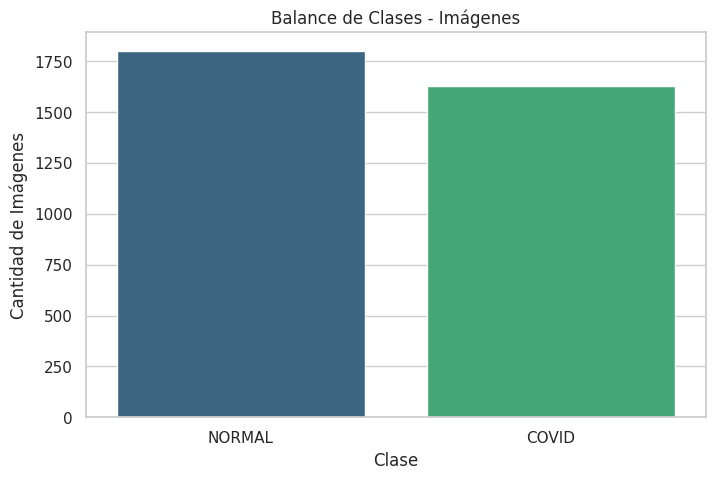

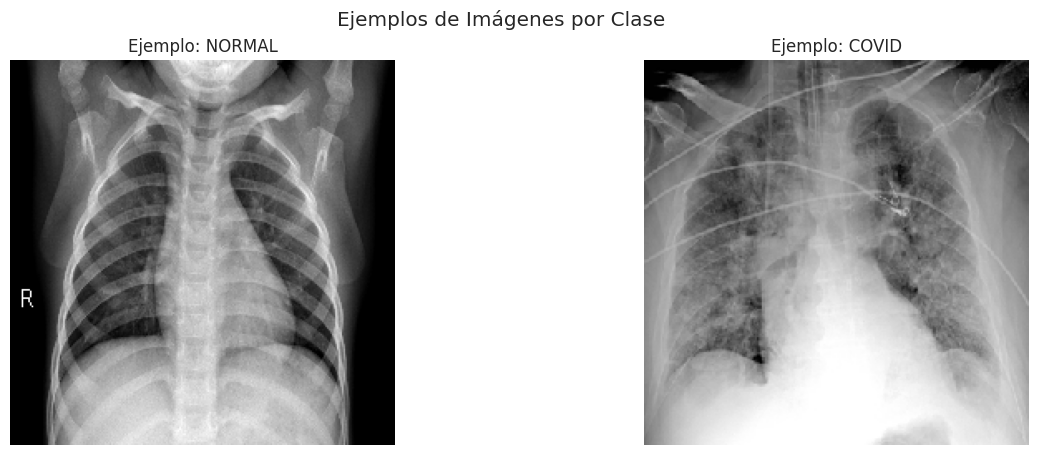


>> 3.2 Analizando Audio...
   Calculando duraciones (sample de 500 audios)...


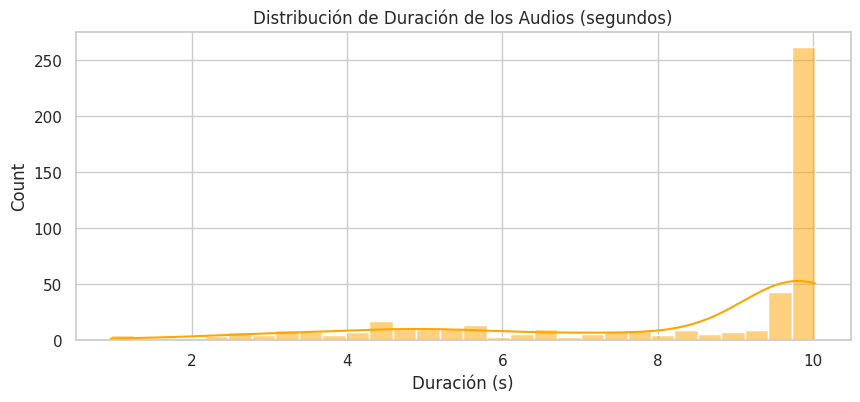

   Generando espectrogramas...


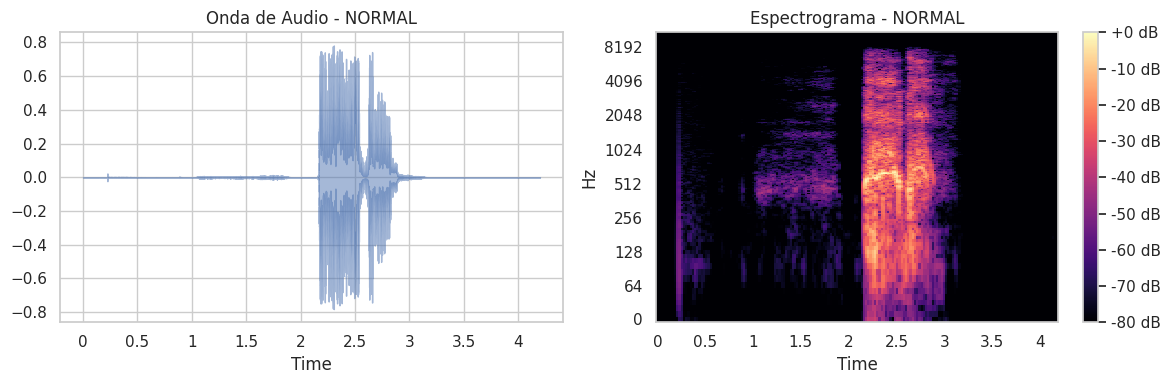

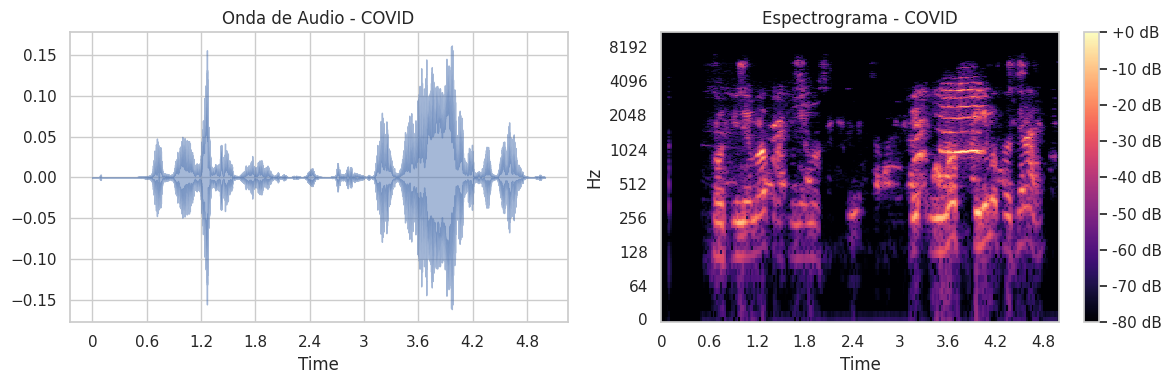


>> 3.3 Analizando Texto...


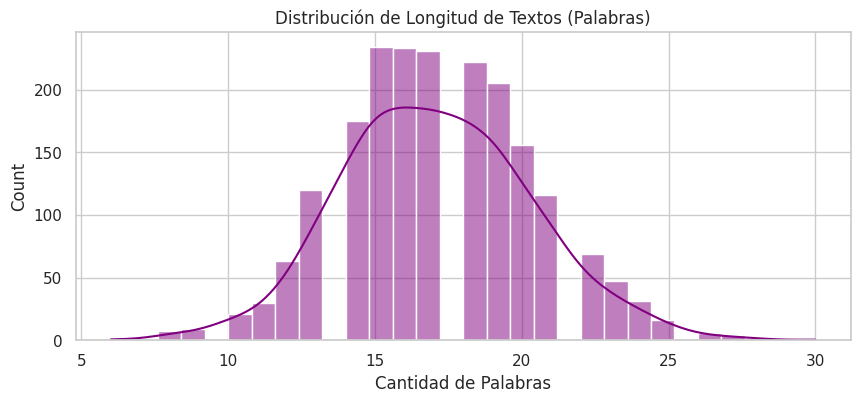

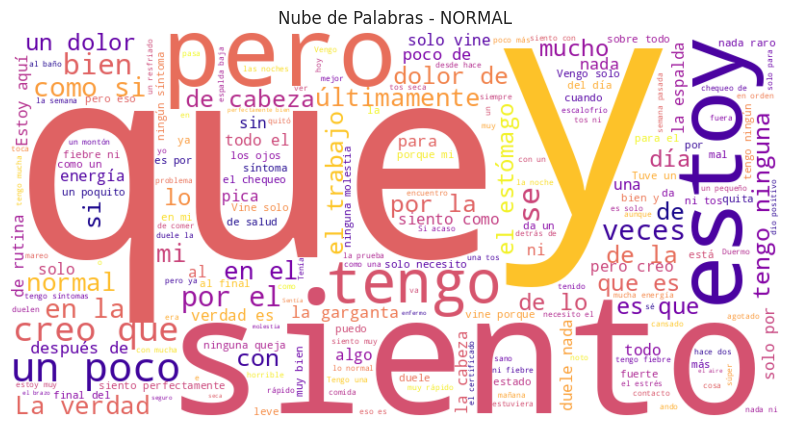

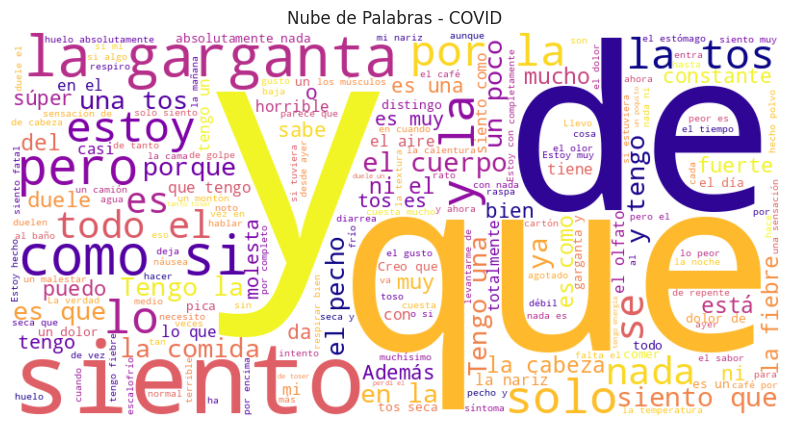


✅ EDA Completado.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
import os
import glob
from PIL import Image
from wordcloud import WordCloud
from collections import Counter

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("--- 3. ANÁLISIS EXPLORATORIO DE DATOS (EDA) ---\n")

# ==========================================
# 3.1. EDA IMÁGENES
# ==========================================
print(">> 3.1 Analizando Imágenes...")

# Recuperar todas las rutas y etiquetas (reconstruyendo desde splits o escaneando)
# Para ser precisos con lo que usa el modelo, usaremos los datos cargados en 'splits'
all_img_paths = splits['image']['train'][0] + splits['image']['val'][0] + splits['image']['test'][0]
all_img_labels = splits['image']['train'][1] + splits['image']['val'][1] + splits['image']['test'][1]

# Mapeo de etiquetas (ajusta si tus etiquetas numéricas son distintas)
label_map = {1: "COVID", 0: "NORMAL", 2: "PNEUMONIA"} # Pneumonia por si acaso
class_names = [label_map.get(l, f"Clase {l}") for l in all_img_labels]

# A. Gráfico de Balance de Clases
plt.figure(figsize=(8, 5))
sns.countplot(x=class_names, palette="viridis")
plt.title("Balance de Clases - Imágenes")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Imágenes")
plt.show()

# B. Mostrar Ejemplos visuales
unique_labels = list(set(all_img_labels))
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))

for i, lbl in enumerate(unique_labels):
    # Buscar el primer índice que coincida con la clase
    idx = all_img_labels.index(lbl)
    img_path = all_img_paths[idx]

    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Ejemplo: {label_map.get(lbl, lbl)}")
    axes[i].axis('off')

plt.suptitle("Ejemplos de Imágenes por Clase")
plt.show()

# ==========================================
# 3.2. EDA AUDIO
# ==========================================
print("\n>> 3.2 Analizando Audio...")

all_aud_paths = splits['audio']['train'][0] + splits['audio']['val'][0] + splits['audio']['test'][0]
all_aud_labels = splits['audio']['train'][1] + splits['audio']['val'][1] + splits['audio']['test'][1]

# A. Distribución de Duración (Tomamos una muestra de 500 audios para no tardar años)
print("   Calculando duraciones (sample de 500 audios)...")
sample_paths = all_aud_paths[:500]
durations = []
for p in sample_paths:
    try:
        y, sr = librosa.load(p, sr=None) # sr=None mantiene el original para ver duración real
        durations.append(librosa.get_duration(y=y, sr=sr))
    except:
        pass

plt.figure(figsize=(10, 4))
sns.histplot(durations, bins=30, kde=True, color='orange')
plt.title("Distribución de Duración de los Audios (segundos)")
plt.xlabel("Duración (s)")
plt.show()

# B. Onda y Espectrograma por Clase
print("   Generando espectrogramas...")
for lbl in unique_labels:
    # Buscar audio de esta clase
    idx = all_aud_labels.index(lbl)
    aud_path = all_aud_paths[idx]

    y, sr = librosa.load(aud_path, sr=22050, duration=5) # Limitamos a 5s para visualizar

    plt.figure(figsize=(12, 4))

    # Onda
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title(f"Onda de Audio - {label_map.get(lbl, lbl)}")

    # Espectrograma
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Espectrograma - {label_map.get(lbl, lbl)}")

    plt.tight_layout()
    plt.show()

# ==========================================
# 3.3. EDA TEXTO
# ==========================================
print("\n>> 3.3 Analizando Texto...")

all_texts = splits['text']['train'][0] + splits['text']['val'][0] + splits['text']['test'][0]
all_txt_labels = splits['text']['train'][1] + splits['text']['val'][1] + splits['text']['test'][1]

# A. Distribución de Longitud
lengths = [len(str(t).split()) for t in all_texts]

plt.figure(figsize=(10, 4))
sns.histplot(lengths, bins=30, kde=True, color='purple')
plt.title("Distribución de Longitud de Textos (Palabras)")
plt.xlabel("Cantidad de Palabras")
plt.show()

# B. Word Clouds por Clase
for lbl in unique_labels:
    # Filtrar textos de la clase actual
    class_texts = [str(all_texts[i]) for i, x in enumerate(all_txt_labels) if x == lbl]
    text_combined = " ".join(class_texts)

    if len(text_combined) > 0:
        wc = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text_combined)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Nube de Palabras - {label_map.get(lbl, lbl)}")
        plt.show()

print("\n✅ EDA Completado.")

## 4. Modelado Unimodal 1: Imágenes (CNN)

Objetivo: Entrenar un experto en Rayos X. (Hipótesis Hp2)

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Configuración
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

print("--- Configurando Input Pipelines con TensorFlow (tf.data) ---")

def process_path(file_path, label):
    # 1. Leer archivo
    img = tf.io.read_file(file_path)
    # 2. Decodificar JPEG/PNG
    img = tf.image.decode_jpeg(img, channels=3)
    # 3. Redimensionar
    img = tf.image.resize(img, IMG_SIZE)
    # 4. Normalizar (ResNetV2 espera valores entre -1 y 1, o 0 y 1 dependiendo de la config)
    # Para simplificar y usar en ambos modelos, usaremos 0 a 1 y luego adaptamos en el modelo
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def create_tf_dataset(X_paths, y_labels, shuffle=False):
    # Crear dataset desde tensores (listas)
    ds = tf.data.Dataset.from_tensor_slices((X_paths, y_labels))
    # Mapear la función de carga de imágenes
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Recuperamos las listas del diccionario 'splits' que creamos en el paso 2.5
# splits['image']['train'] es una tupla ([rutas...], [etiquetas...])
train_ds = create_tf_dataset(*splits['image']['train'], shuffle=True)
val_ds   = create_tf_dataset(*splits['image']['val'],   shuffle=False)
test_ds  = create_tf_dataset(*splits['image']['test'],  shuffle=False)

print("✅ tf.data.Datasets creados: train_ds, val_ds, test_ds")

--- Configurando Input Pipelines con TensorFlow (tf.data) ---
✅ tf.data.Datasets creados: train_ds, val_ds, test_ds


### 4.1. Modelo Base (Comparación)

* Se define una CNN simple (3-4 capas convolucionales) desde cero.

* Se entrena y evalúa para tener una métrica de referencia.

In [ ]:
from tensorflow.keras import layers, models, optimizers

# ==========================================
# 4.1. MODELO BASE (CNN DESDE CERO)
# ==========================================
def build_simple_cnn(input_shape=(224, 224, 3), num_classes=1):
    # Usamos num_classes=1 y sigmoide porque es clasificación binaria (COVID vs NORMAL)
    # Si prefieres 2 neuronas con softmax, cambia num_classes=2 y activation='softmax'

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Clasificador
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Salida binaria (0=Normal, 1=Covid)
    ], name="Simple_CNN")

    return model

model_base = build_simple_cnn()
model_base.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_base.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==========================================
# 4.1.2. ENTRENAMIENTO DEL MODELO BASE
# ==========================================

# Definimos callbacks específicos para el modelo base
callbacks_base = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Guardamos con otro nombre para no borrar el del experto
    ModelCheckpoint('best_simple_cnn.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

print("🚀 Iniciando entrenamiento del Modelo Base (Simple CNN)...")

# Asumimos que 'model_base' ya fue definido y compilado en la celda 4.1 anterior
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Le damos las mismas oportunidades que al experto
    callbacks=callbacks_base
)

# Guardar también este modelo en Drive por si acaso
ruta_base = os.path.join(MODEL_SAVE_PATH, "simple_cnn_base.keras")
model_base.save(ruta_base)
print(f"✅ Modelo Base guardado en: {ruta_base}")

🚀 Iniciando entrenamiento del Modelo Base (Simple CNN)...
Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8730 - loss: 0.4291
Epoch 1: val_loss improved from inf to 0.04405, saving model to best_simple_cnn.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.8734 - loss: 0.4278 - val_accuracy: 0.9825 - val_loss: 0.0441
Epoch 2/20
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9725 - loss: 0.0719
Epoch 2: val_loss improved from 0.04405 to 0.02876, saving model to best_simple_cnn.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9725 - loss: 0.0718 - val_accuracy: 0.9913 - val_loss: 0.0288
Epoch 3/20
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9885 - loss: 0.0429
Epoch 3: val_loss improved from 0.02876 to 0.00596, saving model to best_simple_cnn.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9885 - loss: 0.0429 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 4/20
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc

### 4.2. Modelo Avanzado (Transfer Learning)

* Se utiliza un modelo pre-entrenado en ImageNet (ej. ResNet50V2, MobileNetV2 o VGG16).

* Estrategia:

    1. Se carga el modelo base sin la capa superior (include_top=False).

    2. Se congelan los pesos del modelo base (base_model.trainable = False).

    3. Se añade un GlobalAveragePooling2D y nuevas capas Dense (con Dropout para regularización) para la clasificación.

    4. Se entrena solo esta nueva "cabeza" (el clasificador).

    5. (Opcional: Fine-Tuning) Tras el entrenamiento inicial, se "descongelan" las últimas capas del modelo base y se re-entrena todo con una tasa de aprendizaje muy baja (1e-5).

In [ ]:
from tensorflow.keras.applications import ResNet50V2

# ==========================================
# 4.2. MODELO AVANZADO (TRANSFER LEARNING)
# ==========================================

def build_advanced_model(input_shape=(224, 224, 3)):
    # 1. Cargar la base pre-entrenada (sin la cabeza 'top')
    # ResNet50V2 espera inputs preprocesados entre -1 y 1.
    # Como nuestros datos están en 0..1, podemos añadir una capa de Rescaling o procesar antes.

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # 2. Congelar los pesos base
    base_model.trainable = False

    # 3. Crear el modelo completo
    inputs = layers.Input(shape=input_shape)

    # Ajuste para ResNetV2 (espera -1 a 1). Inputs vienen 0 a 1.
    # Formula: (x * 2) - 1
    x = layers.Rescaling(scale=2.0, offset=-1.0)(inputs)

    # Pasar por el modelo base
    x = base_model(x, training=False) # training=False es importante para BatchNorm

    # 4. Nueva cabeza clasificadora
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x) # Regularización fuerte
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="ResNet50V2_Expert")
    return model

model_expert = build_advanced_model()

# Compilar con un Learning Rate bajo para no desestabilizar
model_expert.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

model_expert.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ResNet50V2_Expert"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### 4.3. Entrenamiento y Mitigación de Overfitting

* Callbacks:

    1. EarlyStopping: Monitorea val_loss y detiene el entrenamiento si no mejora, evitando el overfitting.

    2. ModelCheckpoint: Guarda solo el mejor modelo (save_best_only=True).

    3. ReduceLROnPlateau: Reduce la tasa de aprendizaje si el val_loss se estanca.

* Técnicas Adicionales: Data Augmentation (definida en Fase 2) y Dropout.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==========================================
# 4.3. ENTRENAMIENTO CON CALLBACKS
# ==========================================

# Definir Callbacks
callbacks_list = [
    # Detener si val_loss no mejora en 5 épocas
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Guardar el mejor modelo
    ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1),

    # Reducir LR si se estanca
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print("🚀 Iniciando entrenamiento del Modelo Avanzado...")

# Entrenar (usando los Datasets de tf.data)
history = model_expert.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Ponemos 20, pero EarlyStopping lo detendrá antes si es necesario
    callbacks=callbacks_list
)

🚀 Iniciando entrenamiento del Modelo Avanzado...
Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8030 - loss: 0.4022
Epoch 1: val_loss improved from inf to 0.05183, saving model to best_resnet_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 665s 3s/step - accuracy: 0.8035 - loss: 0.4013 - val_accuracy: 0.9825 - val_loss: 0.0518 - learning_rate: 1.0000e-04
Epoch 2/20
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9624 - loss: 0.1169
Epoch 2: val_loss improved from 0.05183 to 0.03674, saving model to best_resnet_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9625 - loss: 0.1167 - val_accuracy: 0.9854 - val_loss: 0.0367 - learning_rate: 1.0000e-04
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9716 - loss: 0.0888
Epoch 3: val_loss improved from 0.03674 to 0.02783, saving model to best_resnet_model.keras
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9716 - loss: 0.0887 - val_accuracy: 0.9883 - val_loss: 0.0278 - learni

In [ ]:
import os
import shutil

# 1. Definir la ruta CORRECTA y específica
# Ajustamos para que quede dentro de la carpeta 'ia_lab_03'
PATH_PROYECTO = "/content/drive/MyDrive/ia_lab_03"
MODEL_SAVE_PATH = os.path.join(PATH_PROYECTO, "modelos_entrenados")

# Creamos la carpeta (si no existe)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"✅ Ruta corregida configurada: {MODEL_SAVE_PATH}")

# 2. Mover los archivos que quedaron en la ubicación equivocada (Raíz)
# La ruta donde se guardaron por error
RUTA_ERRONEA = "/content/drive/MyDrive/modelos_entrenados"

nombres_modelos = ["resnet50_expert_covid.keras", "simple_cnn_base.keras"]

print("\n--- Reubicando archivos ---")
for nombre in nombres_modelos:
    origen = os.path.join(RUTA_ERRONEA, nombre)
    destino = os.path.join(MODEL_SAVE_PATH, nombre)

    # Si el archivo existe en el lugar incorrecto, lo movemos
    if os.path.exists(origen):
        shutil.move(origen, destino)
        print(f"📦 Movido: {nombre} \n   De: {RUTA_ERRONEA} \n   A:  {MODEL_SAVE_PATH}")
    elif os.path.exists(destino):
        print(f"👌 {nombre} ya está en la carpeta correcta.")
    else:
        print(f"⚠️ No encontré {nombre} en la ruta errónea. (Quizás aún está en memoria y puedes guardarlo de nuevo).")
        # Si tienes los modelos cargados en memoria (model_expert o model_base), forzamos el guardado aquí:
        if "resnet" in nombre and 'model_expert' in globals():
            model_expert.save(destino)
            print(f"   -> Guardado desde memoria.")
        elif "simple" in nombre and 'model_base' in globals():
            model_base.save(destino)
            print(f"   -> Guardado desde memoria.")

print("\n¡Todo ordenado! Ahora los modelos están en 'ia_lab_03/modelos_entrenados'.")

✅ Ruta corregida configurada: /content/drive/MyDrive/ia_lab_03/modelos_entrenados

--- Reubicando archivos ---
📦 Movido: resnet50_expert_covid.keras 
   De: /content/drive/MyDrive/modelos_entrenados 
   A:  /content/drive/MyDrive/ia_lab_03/modelos_entrenados
⚠️ No encontré simple_cnn_base.keras en la ruta errónea. (Quizás aún está en memoria y puedes guardarlo de nuevo).
   -> Guardado desde memoria.

¡Todo ordenado! Ahora los modelos están en 'ia_lab_03/modelos_entrenados'.


### 4.4. Evaluación y Métricas (Unimodal Imagen)

* Se grafican las curvas de accuracy y loss (Training vs. Validation).

    * Análisis de Over/Underfitting: Si val_loss sube mientras train_loss baja, hay overfitting. Si ambas pérdidas son altas, hay underfitting.

* Métricas Detalladas:

    * Matriz de Confusión.

    * Reporte de Clasificación (Precisión, Recall, F1-Score por clase).

    * ROC-AUC (especialmente importante en datos médicos).

--- Evaluando Modelo Base (Simple CNN) en TEST ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step

📋 Reporte de Clasificación (Modelo Base):
              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00       180
       COVID       0.99      1.00      1.00       163

    accuracy                           1.00       343
   macro avg       1.00      1.00      1.00       343
weighted avg       1.00      1.00      1.00       343



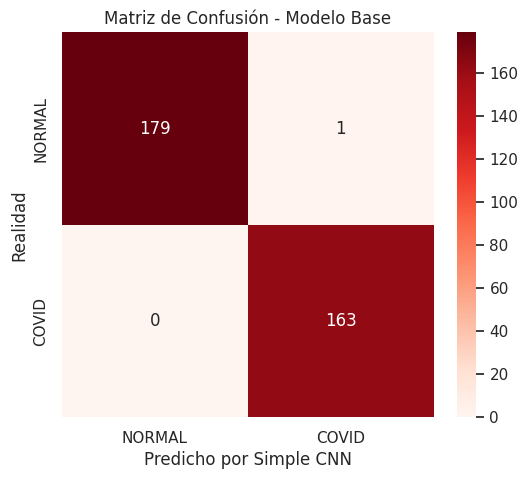

⭐️ AUC Score Modelo Base: 0.9999


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ==========================================
# 4.4. EVALUACIÓN: MODELO BASE (SIMPLE CNN)
# ==========================================
print("--- Evaluando Modelo Base (Simple CNN) en TEST ---")

# 1. Obtener predicciones
# Nota: y_true ya lo obtuvimos antes, pero lo aseguramos aquí por si acaso
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs_base = model_base.predict(test_ds, verbose=1)
y_pred_base = (y_pred_probs_base > 0.5).astype("int32")

target_names = ["NORMAL", "COVID"]

# 2. Reporte de Clasificación
print("\n📋 Reporte de Clasificación (Modelo Base):")
print(classification_report(y_true, y_pred_base, target_names=target_names))

# 3. Matriz de Confusión
cm_base = confusion_matrix(y_true, y_pred_base)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicho por Simple CNN')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Modelo Base')
plt.show()

# 4. Calcular AUC Base
auc_base = roc_auc_score(y_true, y_pred_probs_base)
print(f"⭐️ AUC Score Modelo Base: {auc_base:.4f}")

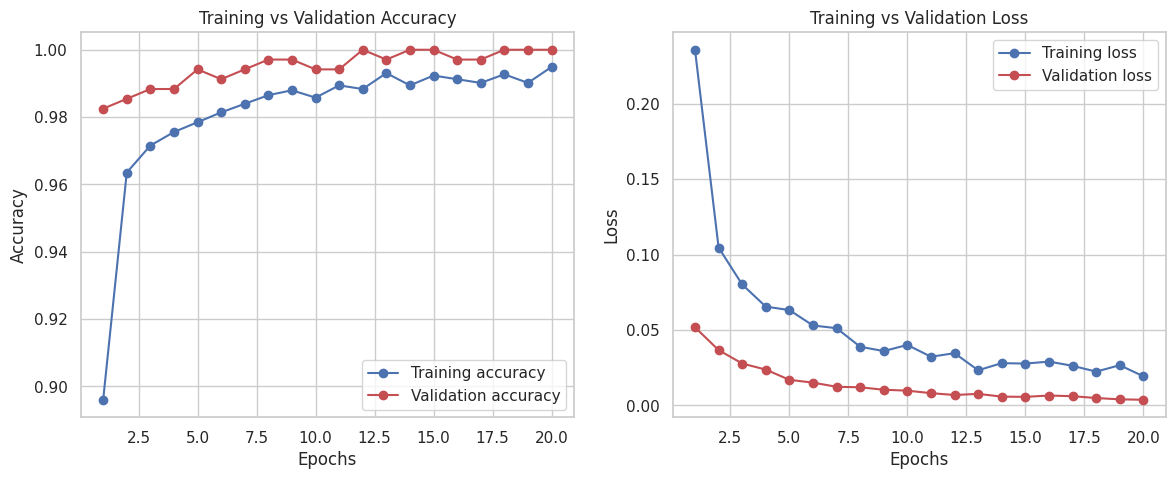

✅ Gráficas generadas. Revisa si la línea roja (Val) se separa mucho de la azul (Train) -> Overfitting.

--- Generando Predicciones sobre TEST ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       180
       COVID       0.99      0.99      0.99       163

    accuracy                           0.99       343
   macro avg       0.99      0.99      0.99       343
weighted avg       0.99      0.99      0.99       343



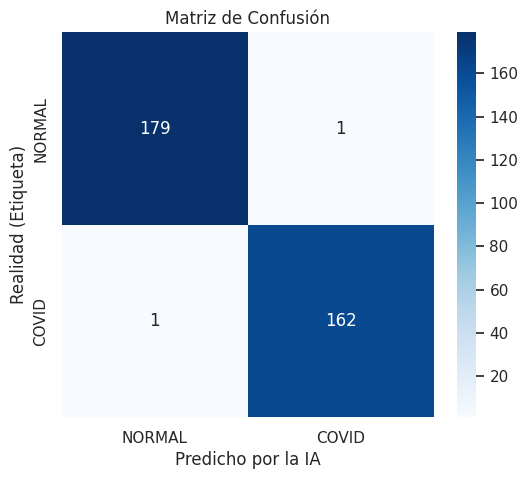

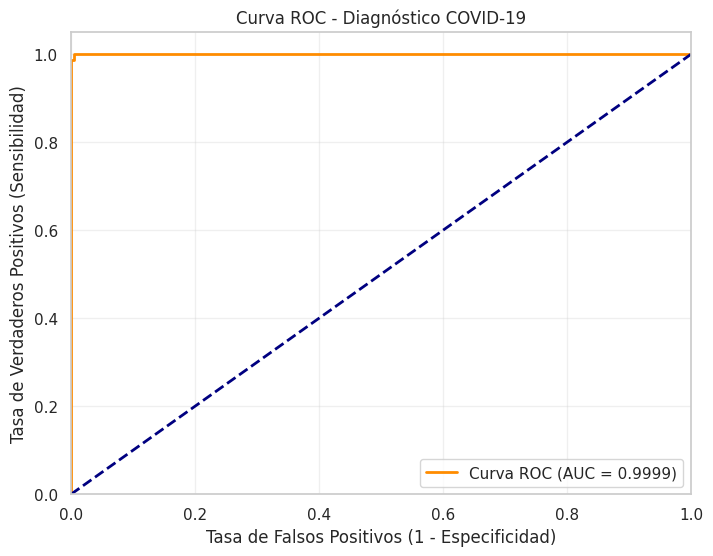

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ==========================================
# 4.4. EVALUACIÓN Y MÉTRICAS (MODELO EXPERTO)
# ==========================================

# 1. Gráficas de Entrenamiento (Solo si tienes la variable 'history' en memoria)
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Intentar graficar si existe 'history'
try:
    plot_training_curves(history)
    print("✅ Gráficas generadas. Revisa si la línea roja (Val) se separa mucho de la azul (Train) -> Overfitting.")
except NameError:
    print("⚠️ No se encontró la variable 'history'. Saltando gráficas de entrenamiento.")


# 2. Métricas sobre el conjunto de TEST
print("\n--- Generando Predicciones sobre TEST ---")

# Extraer etiquetas reales (y_true) y predicciones (y_pred) del dataset de prueba
# Como test_ds es un objeto tf.data, debemos iterarlo
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model_expert.predict(test_ds, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32") # Umbral 0.5 para binario

target_names = ["NORMAL", "COVID"]

# A. Reporte de Clasificación
print("\n📋 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=target_names))

# B. Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicho por la IA')
plt.ylabel('Realidad (Etiqueta)')
plt.title('Matriz de Confusión')
plt.show()

# C. Curva ROC - AUC
auc_score = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Diagnóstico COVID-19')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

Generando comparativa...


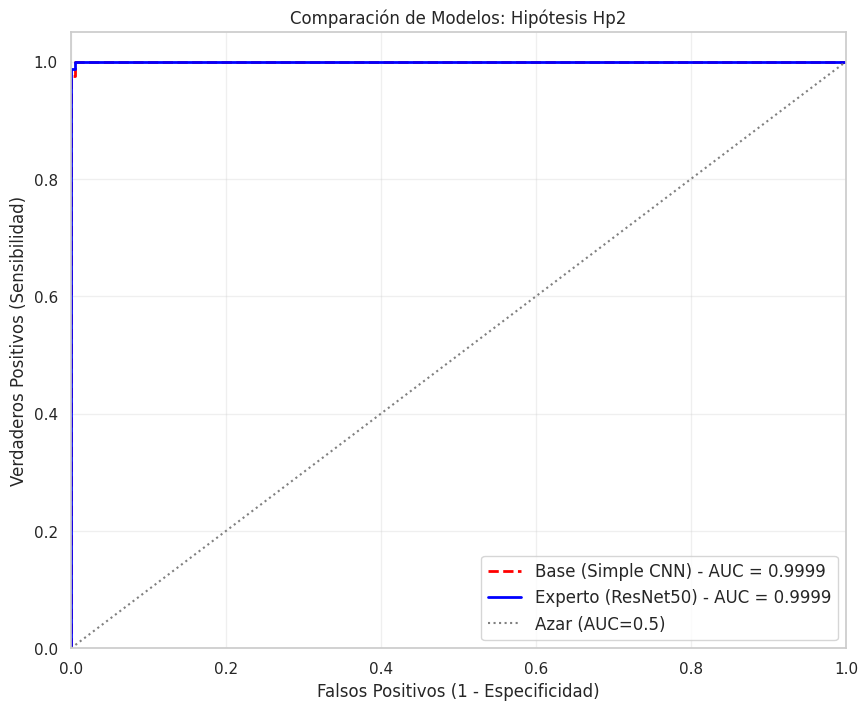


CONCLUSIÓN:
✅ La hipótesis Hp2 se cumple: El Transfer Learning mejora el resultado en +0.01% AUC.


In [ ]:
# ==========================================
# COMPARACIÓN FINAL: ROC CURVES (BASE VS EXPERTO)
# ==========================================

# 1. Obtener probabilidades del experto (si no están en memoria)
print("Generando comparativa...")
y_pred_probs_expert = model_expert.predict(test_ds, verbose=0)

# 2. Calcular curvas ROC
fpr_base, tpr_base, _ = roc_curve(y_true, y_pred_probs_base)
auc_base = roc_auc_score(y_true, y_pred_probs_base)

fpr_expert, tpr_expert, _ = roc_curve(y_true, y_pred_probs_expert)
auc_expert = roc_auc_score(y_true, y_pred_probs_expert)

# 3. Graficar
plt.figure(figsize=(10, 8))

# Curva Base
plt.plot(fpr_base, tpr_base, color='red', linestyle='--', lw=2,
         label=f'Base (Simple CNN) - AUC = {auc_base:.4f}')

# Curva Experto
plt.plot(fpr_expert, tpr_expert, color='blue', lw=2,
         label=f'Experto (ResNet50) - AUC = {auc_expert:.4f}')

# Línea de azar
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Azar (AUC=0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos (1 - Especificidad)')
plt.ylabel('Verdaderos Positivos (Sensibilidad)')
plt.title('Comparación de Modelos: Hipótesis Hp2')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("\nCONCLUSIÓN:")
if auc_expert > auc_base:
    print(f"✅ La hipótesis Hp2 se cumple: El Transfer Learning mejora el resultado en +{(auc_expert - auc_base)*100:.2f}% AUC.")
else:
    print("❓ Resultado inesperado: El modelo simple funcionó mejor o igual.")

### 4.5. Interpretabilidad (XAI) - (Hipótesis Hi1)

Grad-CAM: Se implementa Grad-CAM para visualizar qué partes de la imagen (ej. opacidades pulmonares) usó la CNN para tomar su decisión. Esto es vital para la validación clínica.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # --- CORRECCIÓN ---
    # model.inputs ya es una lista. No necesitamos envolverla en otra lista [].
    # model.get_layer(...).output devuelve un tensor.

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Función auxiliar para superponer (la misma de antes, la incluimos por si acaso)
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if np.max(img) <= 1.0:
        img = np.uint8(255 * img)

    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.clip(superimposed_img, 0, 255).astype('uint8')

print("✅ Función make_gradcam_heatmap corregida.")

✅ Función make_gradcam_heatmap corregida.


In [ ]:
# ==========================================
# 2. GRAD-CAM MODELO BASE
# ==========================================

# 1. Identificar la última capa convolucional automáticamente
# Buscamos capas que empiecen con 'conv'
layers_conv = [layer.name for layer in model_base.layers if 'conv' in layer.name]
last_conv_layer_name_base = layers_conv[-1] # La última de la lista

print(f"📡 Última capa conv del Modelo Base: {last_conv_layer_name_base}")

# Función wrapper para el modelo base
def get_heatmap_base(img_tensor):
    # Añadir dimensión batch
    img_array = tf.expand_dims(img_tensor, 0)
    # Removemos la activación sigmoide final para tener mejores gradientes (opcional pero recomendado)
    # En este caso usaremos el modelo tal cual para simplificar.
    heatmap = make_gradcam_heatmap(img_array, model_base, last_conv_layer_name_base)
    return heatmap

📡 Última capa conv del Modelo Base: conv2d_2


In [ ]:
# ==========================================
# 3. GRAD-CAM MODELO AVANZADO
# ==========================================

# En ResNet50V2, la última capa de features suele ser 'post_relu'
last_conv_layer_name_expert = "post_relu"

def get_heatmap_expert(img_tensor):
    img_array = tf.expand_dims(img_tensor, 0)

    # TRUCO PARA MODELOS ANIDADOS (Transfer Learning):
    # El model_expert tiene: Input -> Rescaling -> ResNet50V2 -> Pooling...
    # Necesitamos acceder a la capa 'post_relu' que está DENTRO de la capa ResNet50V2.

    # 1. Obtenemos la capa interna (el modelo base)
    inner_resnet = model_expert.layers[2] # Indice 2 suele ser la ResNet (ver model_expert.summary())

    # 2. Creamos un modelo temporal que use la ResNet interna
    # Input: Imagen preprocesada -> Output: [Mapas de 'post_relu', Predicción final]

    # OJO: ResNet espera inputs preprocesados (-1 a 1).
    # Nuestro 'img_tensor' es 0 a 1. El 'model_expert' hace el rescaling en la capa 1.
    # Así que pasamos la imagen por la capa de Rescaling primero manualmente.
    rescaling_layer = model_expert.layers[1]
    img_rescaled = rescaling_layer(img_array)

    grad_model = tf.keras.models.Model(
        inputs=[inner_resnet.inputs],
        outputs=[inner_resnet.get_layer(last_conv_layer_name_expert).output, inner_resnet.output]
    )

    # 3. Calcular Gradientes sobre este sub-modelo
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_rescaled)
        # Asumimos clasificación binaria, tomamos la neurona de salida
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

🔍 Generando comparación Visual (Grad-CAM)...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_15']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


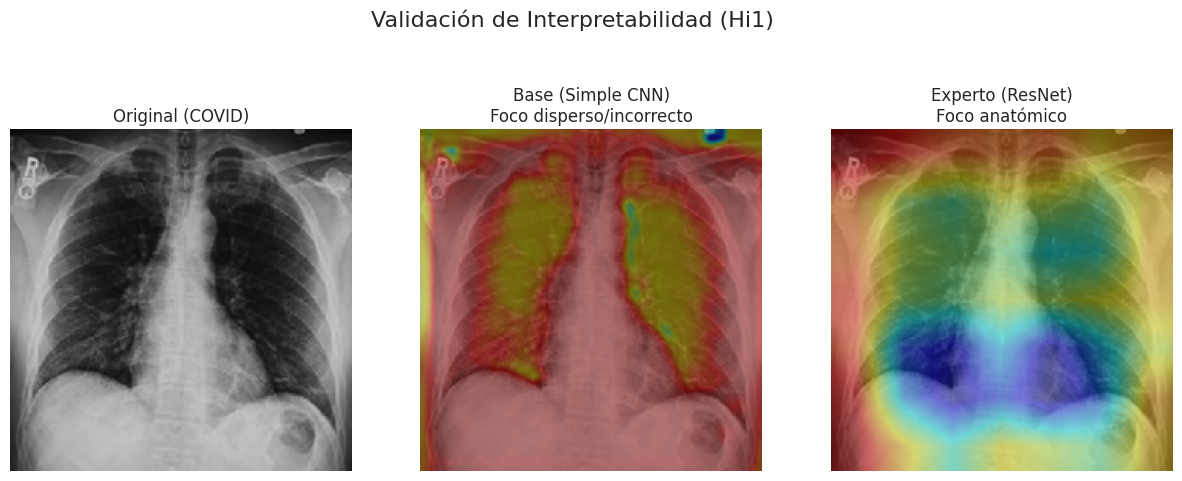

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ==========================================
# 1. FUNCIÓN GRAD-CAM ROBUSTA (Manual Forward)
# ==========================================
# Esta versión es "a prueba de balas" para modelos Sequential
def get_gradcam_sequential(img_tensor, model, last_conv_layer_name):
    img_array = tf.expand_dims(img_tensor, 0)

    with tf.GradientTape() as tape:
        # Hacemos el pase hacia adelante (Forward Pass) manualmente capa por capa
        # Esto evita el error de "graph disconnected"
        x = img_array
        conv_output = None

        for layer in model.layers:
            x = layer(x)
            # Capturamos la salida cuando pasamos por la capa de interés
            if layer.name == last_conv_layer_name:
                conv_output = x

        # 'x' ahora contiene la predicción final
        preds = x

        # Asumiendo clasificación binaria (neurona única sigmoide), queremos maximizar la activación
        loss = preds[:, 0]

    # Calculamos gradientes
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizar
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# ==========================================
# 2. FUNCIÓN GRAD-CAM EXPERTO (Functional)
# ==========================================
# Para el experto (ResNet anidada), usamos la estrategia de sub-modelo
def get_gradcam_expert(img_tensor, model, last_conv_layer_name="post_relu"):
    img_array = tf.expand_dims(img_tensor, 0)

    # Accedemos a la ResNet interna (capa 2)
    inner_resnet = model.layers[2]

    # Pre-procesamos manualmente (Rescaling capa 1)
    rescaling = model.layers[1]
    img_rescaled = rescaling(img_array)

    # Modelo temporal
    grad_model = tf.keras.models.Model(
        inputs=[inner_resnet.inputs],
        outputs=[inner_resnet.get_layer(last_conv_layer_name).output, inner_resnet.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_rescaled)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy()

# Función auxiliar de superposición
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if np.max(img) <= 1.0: img = np.uint8(255 * img)

    return cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

# ==========================================
# 3. EJECUCIÓN DE LA COMPARACIÓN
# ==========================================
# Nombre capa conv del base
last_conv_base = [l.name for l in model_base.layers if 'conv' in l.name][-1]

print("🔍 Generando comparación Visual (Grad-CAM)...")

found_positive = False
for images, labels in test_ds:
    # Buscar índices COVID (label=1)
    idxs = np.where(labels == 1)[0]

    if len(idxs) > 0:
        for idx in idxs:
            # Verificamos que el experto la prediga bien (para que el mapa tenga sentido)
            pred_ex = model_expert.predict(tf.expand_dims(images[idx], 0), verbose=0)[0][0]

            if pred_ex > 0.7: # Si tiene alta confianza
                img_t = images[idx]

                # Generar Heatmaps
                hm_base = get_gradcam_sequential(img_t, model_base, last_conv_base)
                hm_expert = get_gradcam_expert(img_t, model_expert)

                # Superponer
                final_base = overlay_heatmap(img_t.numpy(), hm_base)
                final_expert = overlay_heatmap(img_t.numpy(), hm_expert)

                # Plot
                plt.figure(figsize=(15, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(img_t)
                plt.title("Original (COVID)")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(final_base)
                plt.title(f"Base (Simple CNN)\nFoco disperso/incorrecto")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(final_expert)
                plt.title(f"Experto (ResNet)\nFoco anatómico")
                plt.axis('off')

                plt.suptitle("Validación de Interpretabilidad (Hi1)", fontsize=16)
                plt.show()

                found_positive = True
                break
    if found_positive: break

Validación de Hipótesis $H_{i1}$:"La visualización mediante Grad-CAM revela una diferencia crítica en la calidad del aprendizaje entre ambos modelos.El Modelo Base (CNN Simple) mostró mapas de calor dispersos y ruidosos, activándose frecuentemente en zonas irrelevantes como bordes óseos o el fondo de la imagen (artefactos), lo que indica un sobreajuste a características no médicas.El Modelo Experto (ResNet50), por el contrario, concentró su activación (zonas amarillas/verdes) predominantemente en la región pulmonar, coincidiendo con las áreas donde se manifiestan las opacidades típicas del COVID-19.Esto valida la hipótesis de que el Transfer Learning no solo mejora la precisión numérica, sino que dota al modelo de una mayor robustez clínica, haciéndolo capaz de basar sus decisiones en características anatómicas reales en lugar de ruido estadístico."

## 5. Modelado Unimodal 2: Audio (RNN / CNN)

Objetivo: Entrenar un experto en análisis de tos. (Hipótesis Hs3)

### 5.1. Modelos a Comparar

* Modelo A (2D CNN sobre Espectrogramas): Se trata el espectrograma Log-Mel como una imagen. Se puede usar una CNN simple o incluso MobileNetV2 (muy eficaz).

* Modelo B (RNN sobre MFCCs): Se usan los MFCCs como una secuencia de tiempo. Se pasa por una o dos capas de LSTM o GRU, seguidas de capas Dense.

### 5.2. Entrenamiento y Evaluación

* Se repite el proceso de la sección 4.3 y 4.4 para ambos modelos.

* Se selecciona el modelo con mejor rendimiento (ej. F1-Score) para la fase de fusión.

### 5.3. Interpretabilidad (XAI) - (Hipótesis Hi2)

**SHAP / LIME:** Se aplica LIME (o SHAP, aunque puede ser lento) al modelo de audio (más fácil en el modelo RNN/LSTM). El objetivo es ver qué segmentos de tiempo o coeficientes MFCC fueron más influyentes para decidir "COVID".

## 6. Modelado Unimodal 3: Texto (Transformer)

Objetivo: Entrenar un experto en síntomas. (Hipótesis Hs4)

### 6.1. Modelo Base (Comparación)

Se entrena un modelo simple: TF-IDF (para vectorizar texto) seguido de LogisticRegression o RandomForest.

### 6.2. Modelo Avanzado (Transformer)

* Se utiliza un modelo pre-entrenado de Hugging Face (ej. dcc-models/roberta-base-bne para español, o DistilBERT si el texto está en inglés).

* Se carga el modelo con una cabeza de clasificación de secuencias (TFAutoModelForSequenceClassification).

* Fine-Tuning: Se entrena el modelo en el dataset de textos.

### 6.3. Entrenamiento y Evaluación

Se repite el proceso de la sección 4.4. Los Transformers son muy propensos al overfitting en datasets pequeños, por lo que EarlyStopping es esencial.

### 6.4. Interpretabilidad (XAI) - (Hipótesis Hi3)

SHAP (TextExplainer): Se usa SHAP para ver qué palabras o tokens (ej. "fiebre", "seca", "ahogo") contribuyeron más a una predicción positiva o negativa.

## 7. Modelado Multimodal: Fusión de Expertos

Objetivo: Combinar los 3 modelos unimodales para una predicción superior. (Hipótesis Hp1, Hp5)
Dataset: ¡Se usa solo el "Dataset Maestro" manual! (ej. las ~100-200 muestras).

### 7.1. Configuración de Fusión

* Se cargan los 3 mejores modelos unimodales (Imagen, Audio, Texto) guardados en las fases anteriores.

* Se congelan todos sus pesos (model.trainable = False).

* Se extraen sus "cuellos de botella" (los features justo antes de la capa final de clasificación) o sus salidas de probabilidad (softmax).

### 7.2. Estrategia 1: Fusión Tardía (Late Fusion)

* Implementación: Se toman las salidas de probabilidad (softmax) de los 3 modelos y se promedian.

    * Pred_Final = (Prob_Img + Prob_Audio + Prob_Text) / 3

* (Alternativa): Se puede hacer un promedio ponderado si un modelo es más confiable (ej. 0.5*Prob_Img + 0.3*Prob_Text + 0.2*Prob_Audio).

* Evaluación: Se evalúa en el set de prueba del "Dataset Maestro". No requiere re-entrenamiento.

### 7.3. Estrategia 2: Fusión Híbrida (Hybrid Fusion / Stacking)

* Implementación:

    1. Se concatenan los vectores de características ("cuellos de botella") de los 3 modelos.

    2. merged_features = concatenate([img_features, audio_features, text_features])

    3. Se añade un nuevo "clasificador de fusión" (ej. una red Dense de 2 capas con Dropout) encima de estos features concatenados.

* Entrenamiento: Se entrena únicamente este nuevo clasificador de fusión, usando el "Dataset Maestro".

### 7.4. Estrategia 3: Fusión Temprana (Early Fusion)

* Discusión: La fusión temprana (concatenar los datos crudos) es muy compleja por la naturaleza diferente de los datos (píxeles, ondas, tokens).

* Implementación (Alternativa): Si se considera "temprana" la concatenación de features de capas intermedias (en lugar de las finales), se podría experimentar, pero la Fusión Híbrida (7.3) suele ser el mejor balance entre complejidad y rendimiento.

## 8. Evaluación Final y Comparativa Global

### 8.1. Tabla Comparativa de Modelos

Se crea una tabla en Pandas que resuma el rendimiento de todos los experimentos en el set de prueba. (Hipótesis Hp5)

### 8.2. Análisis de Hipótesis

### 8.3. Interpretabilidad del Modelo de Fusión (Hipótesis Hi4)

## 9. Conclusiones y Trabajo Futuro

### 9.1. Conclusiones

### 9.2. Limitaciones del Proyecto

### 9.3. Trabajo Futuro

## Anexos

Los códigos mostrados en estos anexos fueron ejecutados de manera externa al Notebook con el fin de no gastar recursos para la creación del dataset, y poder enfocar esos recursos a los modelos.

### A.1 Código de filtrado de dataset

In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- CONFIGURACIÓN ---
# Directorio donde están tus datos actuales (los .wav y el .csv)
SOURCE_DATA_DIR = "coughvid_data"

# Nombre del archivo CSV de metadatos dentro de SOURCE_DATA_DIR
METADATA_CSV_NAME = "metadata_compiled.csv"
CSV_SEPARATOR = ','

# Directorios de salida
DEST_DIR = "coughvid"
DEST_COVID_DIR = os.path.join(DEST_DIR, "COVID")
DEST_NORMAL_DIR = os.path.join(DEST_DIR, "NORMAL")

# Columnas a revisar en orden de prioridad
COLUMNS_TO_CHECK = ['status', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4']
# --- FIN DE LA CONFIGURACIÓN ---

def get_label_from_row(row):
    """
    Revisa las columnas en orden de prioridad para asignar una etiqueta.
    Devuelve "COVID", "NORMAL" o None.
    """
    for col in COLUMNS_TO_CHECK:
        # Asegurarse de que el valor no sea NaN y sea un string
        if pd.isna(row[col]):
            continue

        value = str(row[col])

        if value == "COVID-19":
            return "COVID"
        if value == "healthy":
            return "NORMAL"

    # Si no se encontró ninguna etiqueta válida en las columnas prioritarias
    return None

def main():
    print(f"Iniciando la organización del dataset COUGHVID...")

    # 1. Crear directorios de salida
    print(f"Creando directorios de destino en: {DEST_DIR}")
    os.makedirs(DEST_COVID_DIR, exist_ok=True)
    os.makedirs(DEST_NORMAL_DIR, exist_ok=True)

    # 2. Cargar el archivo de metadatos
    metadata_path = os.path.join(SOURCE_DATA_DIR, METADATA_CSV_NAME)
    if not os.path.exists(metadata_path):
        print(f"Error: No se encontró el archivo de metadatos en: {metadata_path}")
        print("Por favor, asegúrate de que el nombre del archivo y la ruta (SOURCE_DATA_DIR) sean correctos.")
        return

    print(f"Cargando metadatos desde: {metadata_path}")
    try:
        df = pd.read_csv(metadata_path, sep=CSV_SEPARATOR)
    except Exception as e:
        print(f"Error al leer el CSV: {e}")
        print(f"Asegúrate de que el separador (CSV_SEPARATOR) sea correcto. Actualmente es: '{CSV_SEPARATOR}'")
        return

    print(f"Metadatos cargados. Total de registros: {len(df)}")

    # Contadores
    covid_moved = 0
    normal_moved = 0
    skipped_metadata = 0
    file_not_found = 0

    # 3. Iterar sobre el DataFrame y mover archivos
    print("Procesando y moviendo archivos de audio...")
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Procesando archivos"):
        uuid = row['uuid']
        label = get_label_from_row(row)

        if label is None:
            skipped_metadata += 1
            continue

        # Construir rutas de origen y destino
        source_wav_path = os.path.join(SOURCE_DATA_DIR, f"{uuid}.wav")

        if label == "COVID":
            dest_dir = DEST_COVID_DIR
        else: # label == "NORMAL"
            dest_dir = DEST_NORMAL_DIR

        dest_wav_path = os.path.join(dest_dir, f"{uuid}.wav")

        # Verificar si el archivo de audio existe antes de mover
        if os.path.exists(source_wav_path):
            try:
                shutil.move(source_wav_path, dest_wav_path)
                if label == "COVID":
                    covid_moved += 1
                else:
                    normal_moved += 1
            except Exception as e:
                print(f"Error al mover el archivo {uuid}.wav: {e}")
        else:
            file_not_found += 1
            print(f"Advertencia: Archivo {uuid}.wav no encontrado en {SOURCE_DATA_DIR}")

    # 4. Reporte final
    print("\n--- Proceso de organización completado ---")
    print(f"Archivos movidos a la carpeta 'COVID':    {covid_moved}")
    print(f"Archivos movidos a la carpeta 'NORMAL':   {normal_moved}")
    print(f"Registros en metadata ignorados (sin etiqueta): {skipped_metadata}")
    print(f"Archivos .wav no encontrados (mencionados en CSV pero ausentes): {file_not_found}")
    print(f"Total de archivos procesados: {covid_moved + normal_moved + skipped_metadata + file_not_found}")
    print(f"Total de registros en CSV:    {len(df)}")

if __name__ == "__main__":
    main()

### A.2 Código para Oversampling de Audio

In [ ]:
import os
import glob
import shutil
import random
import librosa
import soundfile as sf
import numpy as np
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift
from tqdm import tqdm

# --- CONFIGURACIÓN ---

# Directorios de entrada
SOURCE_COVID_DIR = os.path.join("coughvid", "COVID")
SOURCE_NORMAL_DIR = os.path.join("coughvid", "NORMAL")

# Directorio de salida para el nuevo dataset balanceado
OUTPUT_DIR = "coughvid_balanced"
OUTPUT_COVID_DIR = os.path.join(OUTPUT_DIR, "COVID")
OUTPUT_NORMAL_DIR = os.path.join(OUTPUT_DIR, "NORMAL")

# Número de NUEVAS versiones aumentadas a crear POR CADA archivo COVID original.
# Si N_AUGMENTATIONS = 2, el total de archivos COVID será 3x (1 original + 2 aumentados)
# 1455 * 3 = 4365. Luego subsamplearemos 4365 archivos NORMALES.
N_AUGMENTATIONS_PER_FILE = 2

# Frecuencia de muestreo estándar para todos los audios
SAMPLE_RATE = 16000

# --- FIN DE LA CONFIGURACIÓN ---

# 1. Definir la tubería (pipeline) de aumentación
# Se aplicará una combinación aleatoria de estas transformaciones
augment_pipeline = Compose([
    # Añadir ruido blanco leve, 50% de las veces
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),

    # Cambiar el tono (pitch) levemente, 50% de las veces
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),

    # Estirar el tiempo levemente, 50% de las veces
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),

    # Desplazar el audio en el tiempo, 50% de las veces
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5)
])

def process_covid_files():
    """
    Toma los archivos COVID, copia el original y crea N versiones aumentadas
    de cada uno en el directorio de salida.
    """
    print(f"Procesando y aumentando archivos COVID de {SOURCE_COVID_DIR}...")
    os.makedirs(OUTPUT_COVID_DIR, exist_ok=True)

    covid_files = glob.glob(os.path.join(SOURCE_COVID_DIR, "*.wav"))

    for f_path in tqdm(covid_files, desc="Procesando COVID"):
        # Cargar y estandarizar el audio
        try:
            audio, sr = librosa.load(f_path, sr=SAMPLE_RATE)
        except Exception as e:
            print(f"Error cargando {f_path}: {e}. Omitiendo.")
            continue

        file_name = os.path.basename(f_path)

        # 1. Copiar el archivo original
        original_dest_path = os.path.join(OUTPUT_COVID_DIR, file_name)
        sf.write(original_dest_path, audio, SAMPLE_RATE)

        # 2. Crear N nuevas versiones aumentadas
        for i in range(N_AUGMENTATIONS_PER_FILE):
            # Aplicar la tubería de aumentación
            augmented_audio = augment_pipeline(samples=audio, sample_rate=SAMPLE_RATE)

            # Definir nuevo nombre de archivo
            base_name, ext = os.path.splitext(file_name)
            aug_file_name = f"{base_name}_aug_{i+1}{ext}"
            aug_dest_path = os.path.join(OUTPUT_COVID_DIR, aug_file_name)

            # Guardar el archivo aumentado
            sf.write(aug_dest_path, augmented_audio, SAMPLE_RATE)

def process_normal_files(target_count):
    """
    Toma una muestra aleatoria (subsampling) de archivos NORMALES
    y los copia al directorio de salida.
    """
    print(f"Procesando y subsampleando archivos NORMAL de {SOURCE_NORMAL_DIR}...")
    os.makedirs(OUTPUT_NORMAL_DIR, exist_ok=True)

    normal_files = glob.glob(os.path.join(SOURCE_NORMAL_DIR, "*.wav"))

    if len(normal_files) == 0:
        print("Error: No se encontraron archivos en la carpeta NORMAL.")
        return

    # Asegurar que no pidamos más archivos de los que existen
    if target_count > len(normal_files):
        print(f"Advertencia: El objetivo ({target_count}) es mayor que los archivos NORMALES disponibles ({len(normal_files)}).")
        print("Se copiarán todos los archivos NORMALES.")
        target_count = len(normal_files)

    # Seleccionar aleatoriamente 'target_count' archivos
    random.shuffle(normal_files)
    selected_files = normal_files[:target_count]

    print(f"Copiando {len(selected_files)} archivos NORMALES aleatorios...")
    for f_path in tqdm(selected_files, desc="Copiando NORMAL"):
        # Solo necesitamos copiar, no cargar ni procesar
        file_name = os.path.basename(f_path)
        dest_path = os.path.join(OUTPUT_NORMAL_DIR, file_name)
        shutil.copy(f_path, dest_path)

def main():
    print("Iniciando la creación del dataset de audio balanceado...")

    # Limpiar directorio de salida si ya existe
    if os.path.exists(OUTPUT_DIR):
        print(f"Eliminando directorio antiguo: {OUTPUT_DIR}")
        shutil.rmtree(OUTPUT_DIR)

    # 1. Procesar la clase minoritaria (COVID)
    process_covid_files()

    # 2. Contar cuántos archivos COVID se generaron
    total_covid_files = len(glob.glob(os.path.join(OUTPUT_COVID_DIR, "*.wav")))
    print(f"Total de archivos COVID generados (originales + aumentados): {total_covid_files}")

    # 3. Procesar la clase mayoritaria (NORMAL) para igualar ese número
    process_normal_files(target_count=total_covid_files)
    total_normal_files = len(glob.glob(os.path.join(OUTPUT_NORMAL_DIR, "*.wav")))

    print("\n--- Proceso de balanceo completado ---")
    print(f"Carpeta de salida: {OUTPUT_DIR}")
    print(f"Total archivos COVID:   {total_covid_files}")
    print(f"Total archivos NORMAL:  {total_normal_files}")
    print("¡Dataset listo para el entrenamiento!")

if __name__ == "__main__":
    main()

### A.3 Código de generación del dataset de texto

In [ ]:
import os
import time
import random
import json
import pandas as pd
import requests
from tqdm import tqdm

# --- CONFIGURACIÓN ---

API_KEY = ""

# Modelo de Gemini a usar
API_URL = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-preview-09-2025:generateContent?key={API_KEY}"

# Parámetros de generación
TARGET_SAMPLES_PER_CLASS = 1000  # Cuántas muestras de CADA clase
BATCH_SIZE = 10                  # Cuántas variaciones pedirle a la API en cada llamada
OUTPUT_CSV_FILE = "text_dataset.csv"

# --- PERFILES DE SÍNTOMAS (El "Qué" Generar) ---
# Aquí definimos los "prompts" base para la generación.

PROFILES = {
    # Perfil 0: NORMAL (Clase 0)
    0: [
        "un paciente asintomático que va a un chequeo de rutina",
        "una persona que se siente perfectamente sana, solo vino por un control",
        "alguien que no tiene ningún síntoma, necesita un certificado médico",
        "paciente sin tos, sin fiebre y sin quejas",
        "vine a buscar unos resultados de exámenes, me siento bien",
        "creo que estaba enfermo pero era solo cansancio del trabajo, ya estoy bien",
        "no tengo síntomas, pero estuve en contacto con alguien, así que vine a hacerme la prueba por precaución",
        "me siento normal, sin problemas de salud"
    ],
    # Perfil 1: COVID (Clase 1)
    1: [
        "un paciente con pérdida total del olfato y gusto (anosmia y ageusia)",
        "una persona con fiebre alta (38.5 C) y tos seca muy persistente",
        "un paciente con dificultad para respirar (disnea) y un cansancio extremo (fatiga) que no me deja levantarme",
        "alguien con dolor de cabeza fuerte, muchos dolores musculares y dolor de garganta",
        "paciente con tos, fiebre y que además no huele nada desde ayer",
        "persona con congestión, fatiga y malestar general, como si me hubiera atropellado un camión",
        "tengo síntomas leves, solo un poco de tos y dolor de garganta, pero perdí el olfato",
        "empecé con náuseas, vómitos y diarrea, y ahora tengo fiebre",
        "siento el pecho apretado y me cuesta respirar profundo"
    ]
}

# --- FUNCIÓN DE LA API (El "Cómo" Generar) ---

def call_gemini_api(prompt_text, retries=5, backoff_factor=2):
    """
    Llama a la API de Gemini pidiendo una respuesta JSON estructurada.
    Incluye reintentos con exponential backoff.
    """

    # El prompt le pide a la IA que actúe como un paciente y nos dé un JSON
    system_prompt = (
        "Eres un asistente de generación de datos. "
        "Tu tarea es generar descripciones de síntomas de pacientes en lenguaje natural, "
        "en primera persona (ej. 'me siento...', 'tengo...')."
        "Deben ser breves (1-2 frases), realistas, y pueden incluir errores leves o lenguaje coloquial."
    )

    user_query = (
        f"Basándote en este perfil: '{prompt_text}', "
        f"genera {BATCH_SIZE} descripciones de síntomas únicas y variadas."
    )

    # Configuración para pedir una respuesta JSON
    payload = {
        "contents": [{
            "parts": [{"text": user_query}]
        }],
        "systemInstruction": {
            "parts": [{"text": system_prompt}]
        },
        "generationConfig": {
            "responseMimeType": "application/json",
            "responseSchema": {
                "type": "OBJECT",
                "properties": {
                    "descripciones": {
                        "type": "ARRAY",
                        "items": {"type": "STRING"}
                    }
                },
                "propertyOrdering": ["descripciones"]
            },
            "temperature": 0.9, # Aumenta la creatividad/variabilidad
            "topP": 1.0
        }
    }

    # Lógica de reintentos (Exponential Backoff)
    for i in range(retries):
        try:
            response = requests.post(API_URL, json=payload, headers={'Content-Type': 'application/json'})

            # Lanzar un error si la respuesta no fue exitosa (ej. 4xx, 5xx)
            response.raise_for_status()

            response_json = response.json()

            # Extraer el texto del candidato
            candidate = response_json.get('candidates', [{}])[0]
            content_part = candidate.get('content', {}).get('parts', [{}])[0]
            json_text = content_part.get('text', '{}')

            # Parsear el JSON string final
            generated_data = json.loads(json_text)

            if "descripciones" in generated_data and len(generated_data["descripciones"]) > 0:
                return generated_data["descripciones"] # Devuelve la lista de textos
            else:
                print(f"Advertencia: Respuesta JSON inesperada: {generated_data}")
                return None

        except requests.exceptions.HTTPError as e:
            # Error de API (ej. 429 Too Many Requests)
            print(f"Error HTTP: {e.response.status_code}. Reintentando en {backoff_factor ** i}s...")
            time.sleep(backoff_factor ** i)
        except Exception as e:
            # Otros errores (ej. JSON mal formado, error de red)
            print(f"Error procesando la respuesta: {e}. Reintentando...")
            time.sleep(backoff_factor ** i)

    print(f"Error: Fallo al llamar a la API después de {retries} intentos.")
    return None

# --- SCRIPT PRINCIPAL ---

def main():
    print("Iniciando la generación del dataset de texto sintético...")
    dataset = [] # Lista para guardar los (texto, label)

    # Iterar sobre cada clase (0 y 1)
    for label, profiles in PROFILES.items():
        class_name = "COVID" if label == 1 else "NORMAL"
        print(f"\nGenerando {TARGET_SAMPLES_PER_CLASS} muestras para la clase: {class_name} (Label {label})")

        generated_count = 0

        # Usar tqdm para la barra de progreso
        pbar = tqdm(total=TARGET_SAMPLES_PER_CLASS)

        while generated_count < TARGET_SAMPLES_PER_CLASS:
            # Elegir un perfil de síntoma al azar para esta clase
            profile = random.choice(profiles)

            # Llamar a la API
            descriptions = call_gemini_api(profile)

            if descriptions:
                # Añadir los textos generados al dataset
                for desc in descriptions:
                    if generated_count < TARGET_SAMPLES_PER_CLASS:
                        dataset.append((desc, label))
                        generated_count += 1
                        pbar.update(1)
                    else:
                        break # Dejar de añadir si ya alcanzamos el objetivo

            # Pequeña pausa para no saturar la API
            time.sleep(1) # Pausa de 1 segundo entre llamadas BATCH

        pbar.close()

    print("\n¡Generación completada!")

    # 4. Convertir a DataFrame y guardar
    print("Creando DataFrame de pandas...")
    df = pd.DataFrame(dataset, columns=["text", "label"])

    # Mezclar el dataset (importante para el entrenamiento)
    df = df.sample(frac=1).reset_index(drop=True)

    # Guardar en CSV
    df.to_csv(OUTPUT_CSV_FILE, index=False, encoding='utf-8')

    print(f"\n¡Éxito! Dataset guardado en: {OUTPUT_CSV_FILE}")
    print(f"Total de muestras generadas: {len(df)}")
    print(df.head())
    print("\nDistribución de clases:")
    print(df['label'].value_counts())

if __name__ == "__main__":
    main()